# Spatio-temporal mineral prospectivity mapping of Papua New Guinea

### Ehsan Farahbakhsh

*EarthByte Group, School of Geosciences, University of Sydney, NSW 2006, Australia*

In [1]:
# setup the working environment
import warnings
warnings.filterwarnings('ignore')
# warnings.filterwarnings(action='once')

import base64, glob, io, os
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import contextily as cx
import csv
import geopandas as gpd
from IPython.display import HTML
from ipywidgets import interact
import matplotlib as mpl
import matplotlib.cm as cm
from matplotlib.colors import LinearSegmentedColormap, Normalize
from matplotlib.patches import Patch
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from matplotlib.ticker import FormatStrFormatter
import moviepy.editor as mpy
from mpl_toolkits.axes_grid1 import make_axes_locatable
from netCDF4 import Dataset
import numpy as np
import pandas as pd
import plotly.express as px
from pprint import pprint
from pulearn import BaggingPuClassifier
import pygplates
import re
import requests
from scipy import misc, ndimage
from scipy.interpolate import griddata
import seaborn as sns
# import shapefile
from shapely.geometry.polygon import LinearRing
import TopoMap
from tqdm.notebook import tqdm

# machine learning
import sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import KNNImputer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_score, GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler

import convergence
import coregistration
from parameters import parameters
from sampling import *
import Utils

# load parameters
Utils.print_parameters()

Below are the parameters in use. Check the parameters carefully to ensure a sucussful run.
{ 'agegrid_dir': '../Muller_2016/Muller_etal_2016_AREPS_v1.17_netCDF/',
  'agegrid_url': 'https://www.earthbyte.org/webdav/ftp/Data_Collections/Muller_etal_2016_AREPS/Muller_etal_2016_AREPS_Agegrids/Muller_etal_2016_AREPS_Agegrids_v1.17/Muller_etal_2016_AREPS_v1.17_netCDF/Muller_etal_2016_AREPS_v1.17_AgeGrid-{}.nc',
  'anchor_plate_id': 0,
  'case_name': 'default-test-case-name',
  'coastlines_file': '../Muller_2016/Global_EarthByte_230-0Ma_GK07_AREPS_Coastlines.gpmlz',
  'convergence_data_dir': './convergence_kinematic_features/',
  'convergence_data_filename_ext': 'csv',
  'convergence_data_filename_prefix': 'features',
  'coreg_input_dir': './coreg_input/',
  'coreg_input_files': [ 'mineral_occurrences.csv',
                         'random_samples.csv',
                         'target_points'],
  'coreg_output_dir': './coreg_output/',
  'grid_files': [ [ '../Muller_2016/Muller_etal_2016_AREP

# Convergence Kinematic Features

In [2]:
print('Extracting convergence kinematic features ...')
print('This may take a while; please be patient!\n')

# run the convergence script
# this will generate a bunch of subduction convergence kinematics statistics files
# by default, the files are placed in ./convergence_data
convergence.run_it()

# list all the output files
conv_dir = Utils.get_convergence_dir()
files = sorted(glob.glob(conv_dir + '*'), key=os.path.getmtime)
print('The number of generated files:', len(files))

# sample file generated for the current time
time = 0
pd.read_csv(f"{conv_dir}{Utils.get_parameter('convergence_data_filename_prefix')}_\
{time:0.2f}.{Utils.get_parameter('convergence_data_filename_ext')}")

Extracting convergence kinematic features ...
This may take a while; please be patient!

Generating convergence data ...
Convergence data already exist in ./convergence_kinematic_features/.
The number of generated files: 231


trench_lon  trench_lat  conv_rate  conv_angle  trench_abs_rate  \
0        -144.44       60.46       4.76       13.76             1.91   
1        -144.75       60.35       4.79       13.70             1.91   
2        -145.06       60.24       4.81       13.64             1.90   
3        -145.37       60.12       4.83       13.58             1.90   
4        -145.68       60.01       4.85       13.52             1.90   
...          ...         ...        ...         ...              ...   
3056        4.88       36.33       0.71      -20.82            -0.55   
3057        4.63       36.33       0.71      -20.94            -0.55   
3058        4.38       36.33       0.70      -21.05            -0.55   
3059        4.14       36.32       0.70      -21.16            -0.54   
3060        3.92       36.32       0.70      -21.27            -0.54   

      trench_abs_angle  arc_len  trench_norm  subducting_pid  trench_pid  ...  \
0              -135.18     0.19       324.26             901         111  ...   
1              -135.06     0.19       323.98             901         111  ...   
2              -134.94     0.19       323.71             901         111  ...   
3              -134.82     0.19       323.45             901         111  ...   
4              -134.70     0.19       323.18             901         111  ...   
...                ...      ...          ...             ...         ...  ...   
3056             17.06     0.20       359.33             701         707  ...   
3057             17.18     0.20       359.18             701         707  ...   
3058             17.30     0.20       359.04             701         707  ...   
3059             17.42     0.18       358.90             701       70833  ...   
3060             17.54     0.18       358.76             701       70833  ...   

      trench_abs_paral  subducting_abs_rate  subducting_abs_angle  \
0                -1.35                -3.29                 -3.97   
1                -1.35                -3.31                 -3.94   
2                -1.35                -3.34                 -3.91   
3                -1.35                -3.37                 -3.87   
4                -1.35                -3.40                 -3.84   
...                ...                  ...                   ...   
3056              0.16                -1.20                 -4.29   
3057              0.16                -1.19                 -4.32   
3058              0.16                -1.18                 -4.35   
3059              0.16                -1.17                 -4.37   
3060              0.16                -1.17                 -4.40   

      subducting_abs_ortho  subducting_abs_paral  seafloor_age  \
0                     3.28                 -0.23         34.77   
1                     3.31                 -0.23         34.77   
2                     3.33                 -0.23         34.77   
3                     3.36                 -0.23         34.77   
4                     3.39                 -0.23         34.77   
...                    ...                   ...           ...   
3056                  1.19                 -0.09         20.95   
3057                  1.19                 -0.09         20.95   
3058                  1.18                 -0.09         20.51   
3059                  1.17                 -0.09         20.51   
3060                  1.16                 -0.09         20.51   

      subduction_volume_km3y  carbonate_sediment_thickness  \
0                       0.06                         29.96   
1                       0.06                         27.83   
2                       0.06                         27.83   
3                       0.06                         27.83   
4                       0.06                         27.83   
...                      ...                           ...   
3056                    0.01                         48.56   
3057                    0.01                      

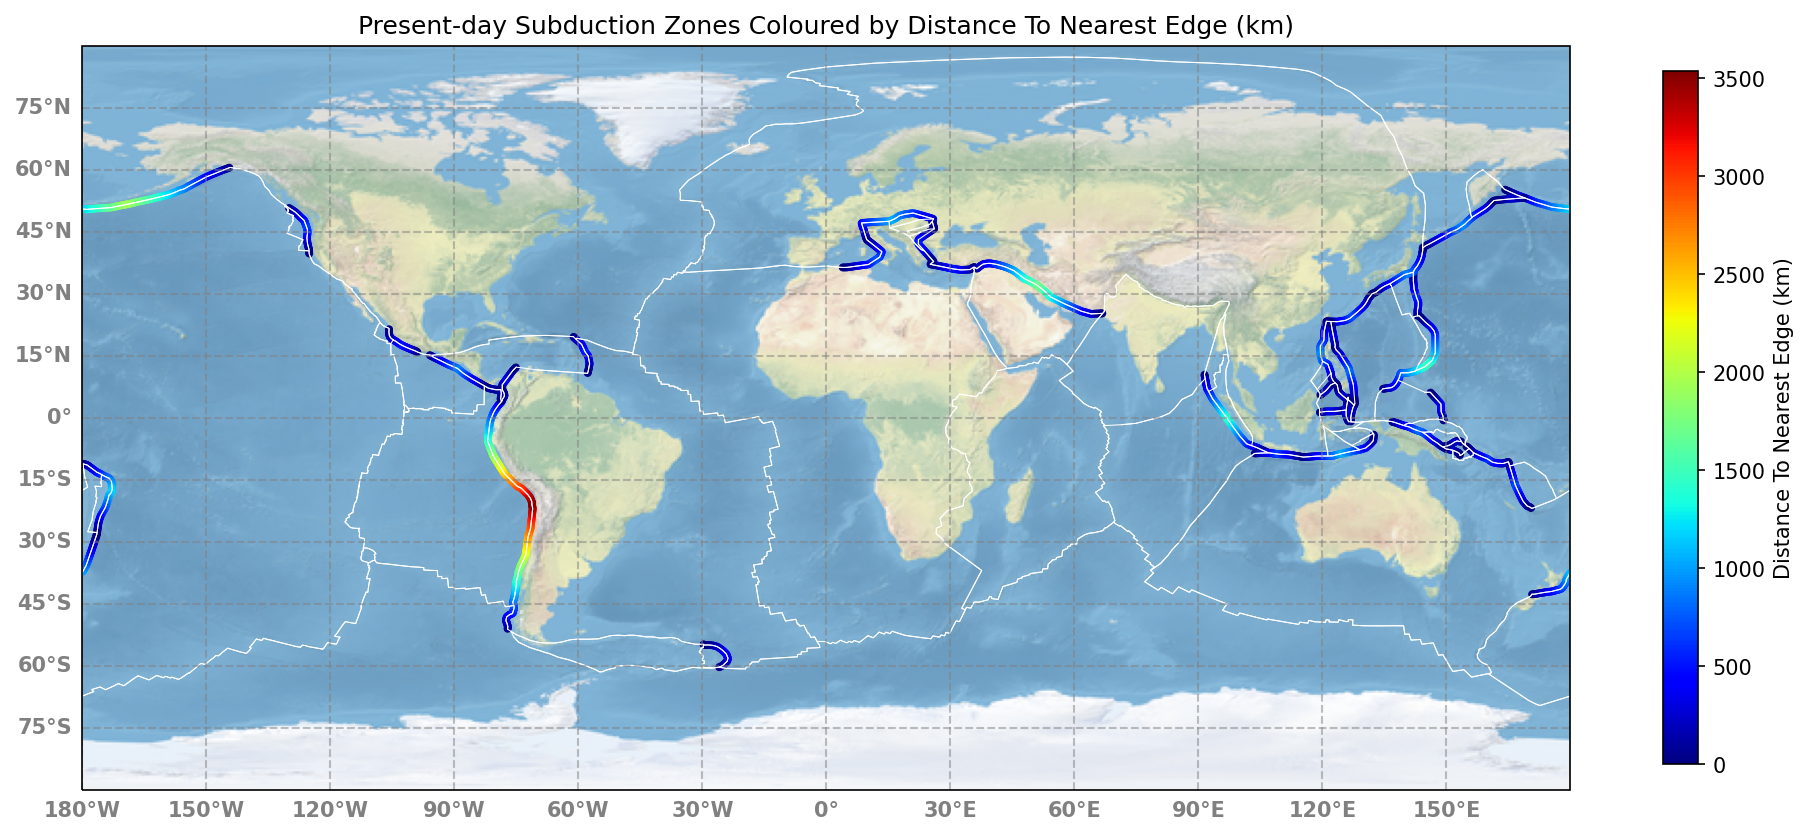

In [3]:
def set_ax(ax, extent, interval_x, interval_y, font_size=None, stock_img=True):
    if stock_img:
        ax.stock_img()

    ax.set_extent(extent)

    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=1, color='gray', alpha=0.5, linestyle='--')
    gl.xlabels_top = False
    gl.ylabels_right = False
    gl.xlocator = mticker.FixedLocator(range(int(extent[0]), int(extent[1]), interval_x))
    gl.ylocator = mticker.FixedLocator(range(int(extent[2]), int(extent[3]), interval_y))
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'color': 'gray', 'weight': 'bold', 'fontsize': font_size}
    gl.ylabel_style = {'color': 'gray', 'weight': 'bold', 'fontsize': font_size}

# change the extent to see a specific area
global_extent = [-180, 180, -90, 90] # global

trench_data = Utils.get_trench_points(time)

rotation_files = Utils.get_files(Utils.get_parameter('rotation_file'))
topology_files = Utils.get_files(Utils.get_parameter('topology_file'))

# use pygplates to resolve the topologies
resolved_topologies = []
shared_boundary_sections = []
pygplates.resolve_topologies(topology_files, rotation_files, resolved_topologies, time, shared_boundary_sections)
geoms = [t.get_resolved_boundary() for t in resolved_topologies]

# plot the data in a global map
fig = plt.figure(figsize=(16, 12), dpi=150)
ax = plt.axes(projection=ccrs.PlateCarree())
set_ax(ax, global_extent, 30, 15)

# topological plate boundaries in black
for geom in geoms:
    lat, lon = zip(*(geom.to_lat_lon_list()))
    plt.plot(lon, lat,
             color='white', linewidth=0.5,
             transform=ccrs.Geodetic()
            )

# trench points are colored based on the values of the selected attribute
cb = ax.scatter(trench_data['trench_lon'], trench_data['trench_lat'], 30, marker='.',
                c=trench_data['dist_nearest_edge'] * 6371. * np.pi / 180, cmap=plt.cm.jet)

plt.title('Present-day Subduction Zones Coloured by Distance To Nearest Edge (km)')
fig.colorbar(cb, shrink=0.5, label='Distance To Nearest Edge (km)')
plt.show()

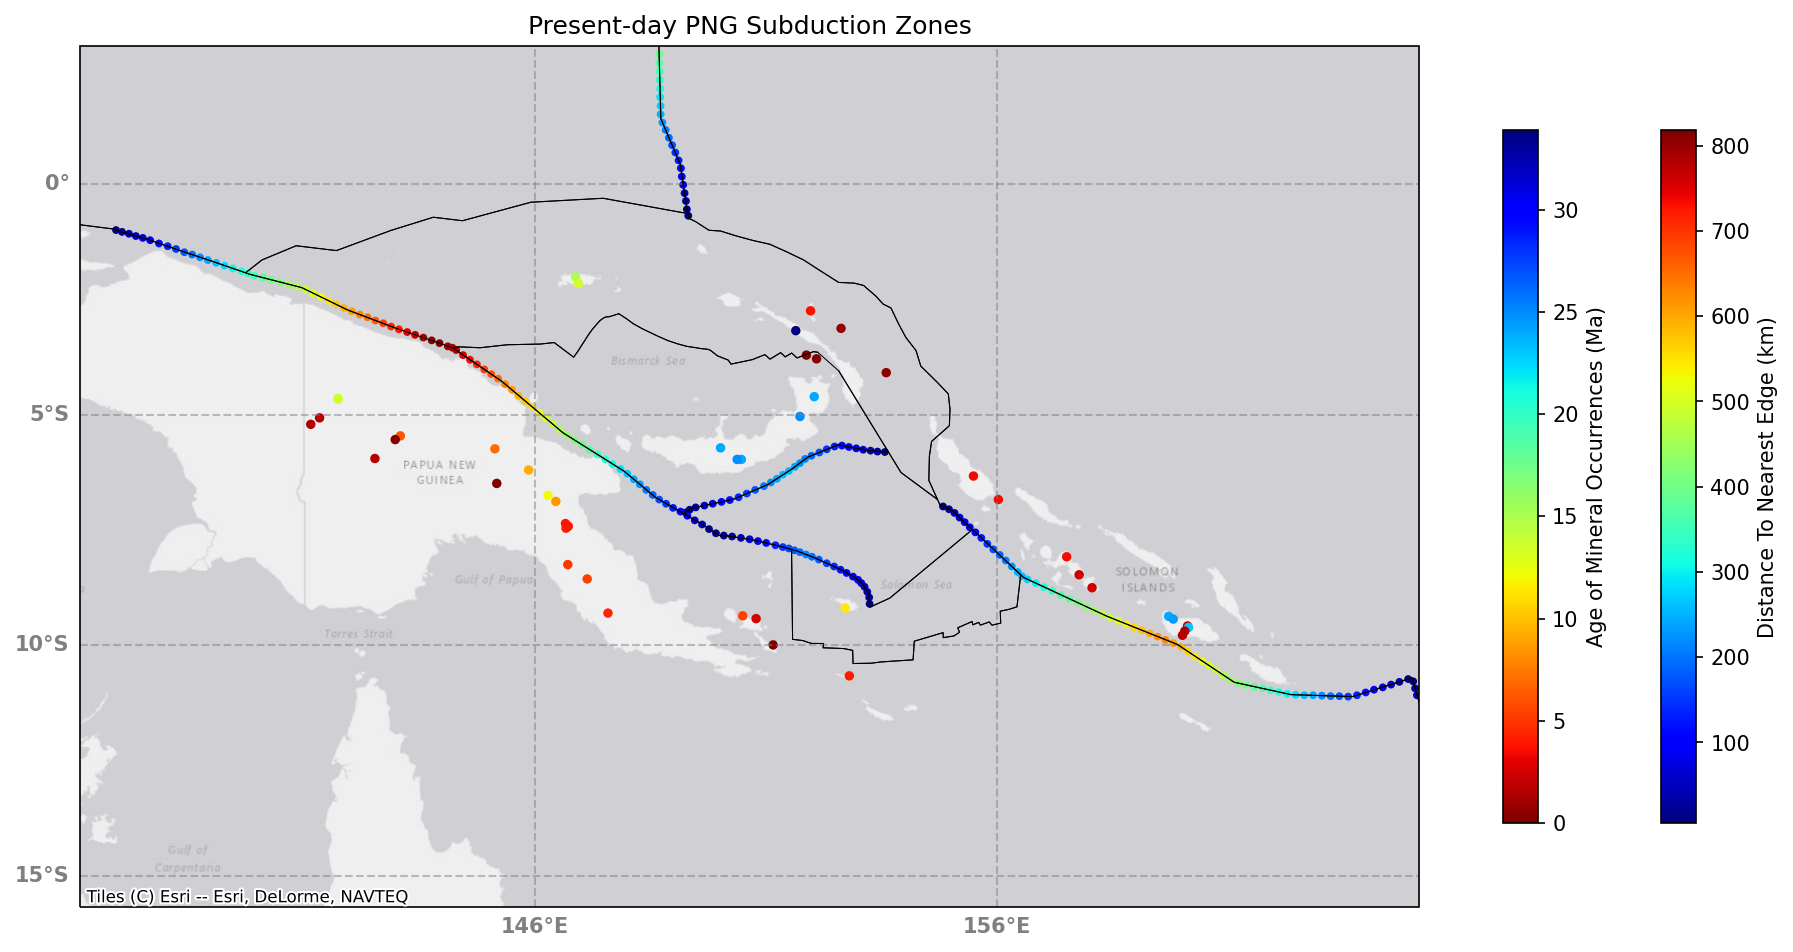

In [4]:
# read the coordinates of the mineral occurrences
min_occ_path = Utils.get_parameter('min_occ_file')
min_occ = gpd.read_file(min_occ_path)

min_lons = min_occ['Longitude']
min_lats = min_occ['Latitude']
min_age = min_occ['Age_From__']

x_min = min_lons.min()
x_max = min_lons.max()
y_min = min_lats.min()
y_max = min_lats.max()

min_occ_extent = [x_min-5, x_max+5, y_min-5, y_max+5]

trench_data = Utils.get_trench_points(time,
                                      top_left_lon=x_min-5,
                                      top_left_lat=y_max+5,
                                      bottom_right_lon=x_max+5,
                                      bottom_right_lat=y_min-5
                                     )

# plot the data in a regional map
fig = plt.figure(figsize=(16, 12), dpi=150)
ax = plt.axes(projection=ccrs.PlateCarree())
set_ax(ax, min_occ_extent, 10, 5, stock_img=False)
cx.add_basemap(ax, crs='EPSG:4326', source=cx.providers.Esri.WorldGrayCanvas)

# topological plate boundaries
for geom in geoms:
    lat, lon = zip(*(geom.to_lat_lon_list()))
    plt.plot(lon, lat,
             color='black', linewidth=0.5,
             transform=ccrs.Geodetic()
            )

# trench points are colored based on the values of the selected attribute
cb1 = ax.scatter(trench_data['trench_lon'], trench_data['trench_lat'], 30, marker='.', 
                c=trench_data['dist_nearest_edge'] * 6371. * np.pi / 180, cmap=plt.cm.jet)
cb2 = ax.scatter(min_lons, min_lats, 50, marker='.', c=min_age, cmap=plt.cm.jet_r)
plt.title('Present-day PNG Subduction Zones')
fig.colorbar(cb1, shrink=0.5, label='Distance To Nearest Edge (km)', pad=-0.05)
fig.colorbar(cb2, shrink=0.5, label='Age of Mineral Occurrences (Ma)', pad=0.05)
plt.show()

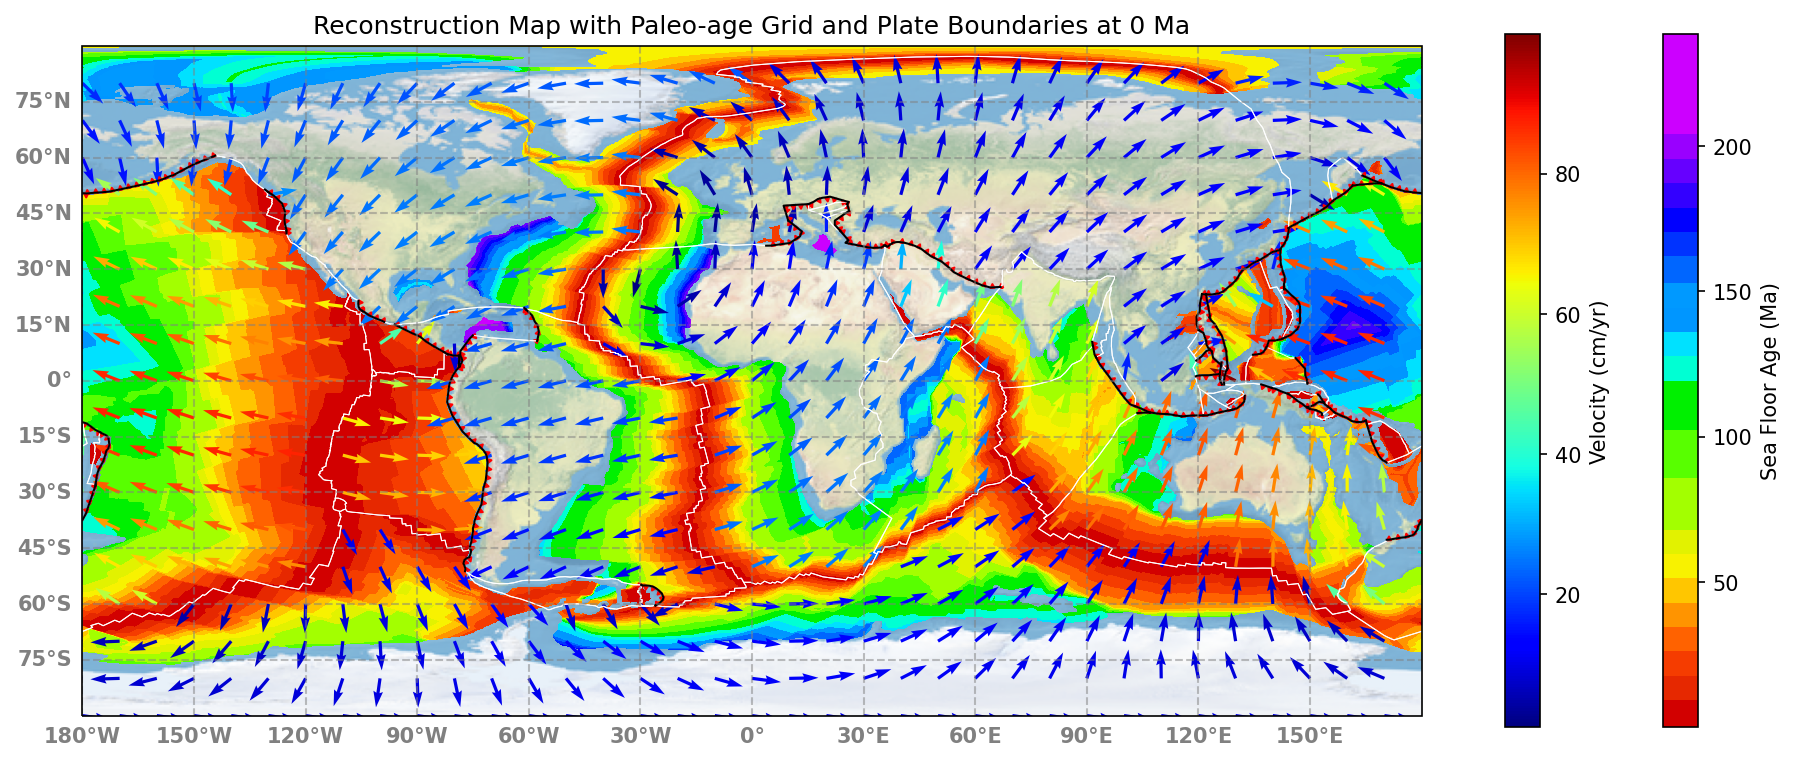

In [5]:
draw_velocity_vectors = True

agegrid_cmap = Utils.get_age_grid_color_map_from_cpt('agegrid.cpt')
agegrid_file = Utils.get_agegrid_dir() + f'Muller_etal_2016_AREPS_v1.17_AgeGrid-{time}.nc'

# subduction zones
subduction_geoms = []
Utils.get_subduction_geometries(subduction_geoms, shared_boundary_sections)

# velocity vectors
x, y, u, v = Utils.get_velocity_x_y_u_v(time, pygplates.RotationModel(rotation_files), topology_files)
       
# plot the map
fig = plt.figure(figsize=(16, 12), dpi=150)
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=0))
set_ax(ax, global_extent, 30, 15)

if agegrid_file:
    img = Dataset(agegrid_file) # age grid
    cb1 = ax.imshow(img.variables['z'], origin='lower', transform=ccrs.PlateCarree(),
                   extent=global_extent, cmap=agegrid_cmap)

# plot topological plate boundaries
for t in resolved_topologies:
    lat, lon = zip(*(t.get_resolved_boundary().to_lat_lon_list()))
    plt.plot(lon, lat,
             color='white', linewidth=0.5,
             transform=ccrs.Geodetic()
            )

# plot subduction zones
for geom, aspect in subduction_geoms:
    lat, lon = zip(*(geom.to_lat_lon_list()))
    plt.plot(lon, lat,
             color='black', linewidth=1,
             transform=ccrs.Geodetic()
            )
    teeth = Utils.get_subduction_teeth(lon, lat, triangle_aspect=aspect)
    for tooth in teeth:
        ring = LinearRing(tooth)
        ax.add_geometries([ring], ccrs.PlateCarree(), facecolor='black', edgecolor='red', alpha=1)

if draw_velocity_vectors:
    # draw velocity vectors
    # some arrows are long and some are very short. To make the plot clearer, we nomalise the velocity magnitude
    # and use color to denote different magnitudes
    u = np.array(u)
    v = np.array(v)
    mag = np.sqrt(u*u+v*v)
    u = u/mag
    v = v/mag
    cb2 = ax.quiver(x, y, u, v, mag, transform=ccrs.PlateCarree(), cmap='jet')

if agegrid_file:
#     plt.title(f'Reconstruction Map with Paleo-age Grid, Paleo-coastlines, and Plate Boundaries at {time} Ma')
    plt.title(f'Reconstruction Map with Paleo-age Grid and Plate Boundaries at {time} Ma')
    fig.colorbar(cb1, shrink=0.5, label='Sea Floor Age (Ma)', pad=-0.05)
    fig.colorbar(cb2, shrink=0.5, label='Velocity (cm/yr)', pad=0.05)
else:
#     plt.title(f'Reconstruction Map with Paleo-coastlines and Plate Boundaries at {time} Ma')
    plt.title(f'Reconstruction Map with Plate Boundaries at {time} Ma')
    fig.colorbar(cb2, shrink=0.5, label='Velocity (cm/yr)', pad=0.05)

plt.show()

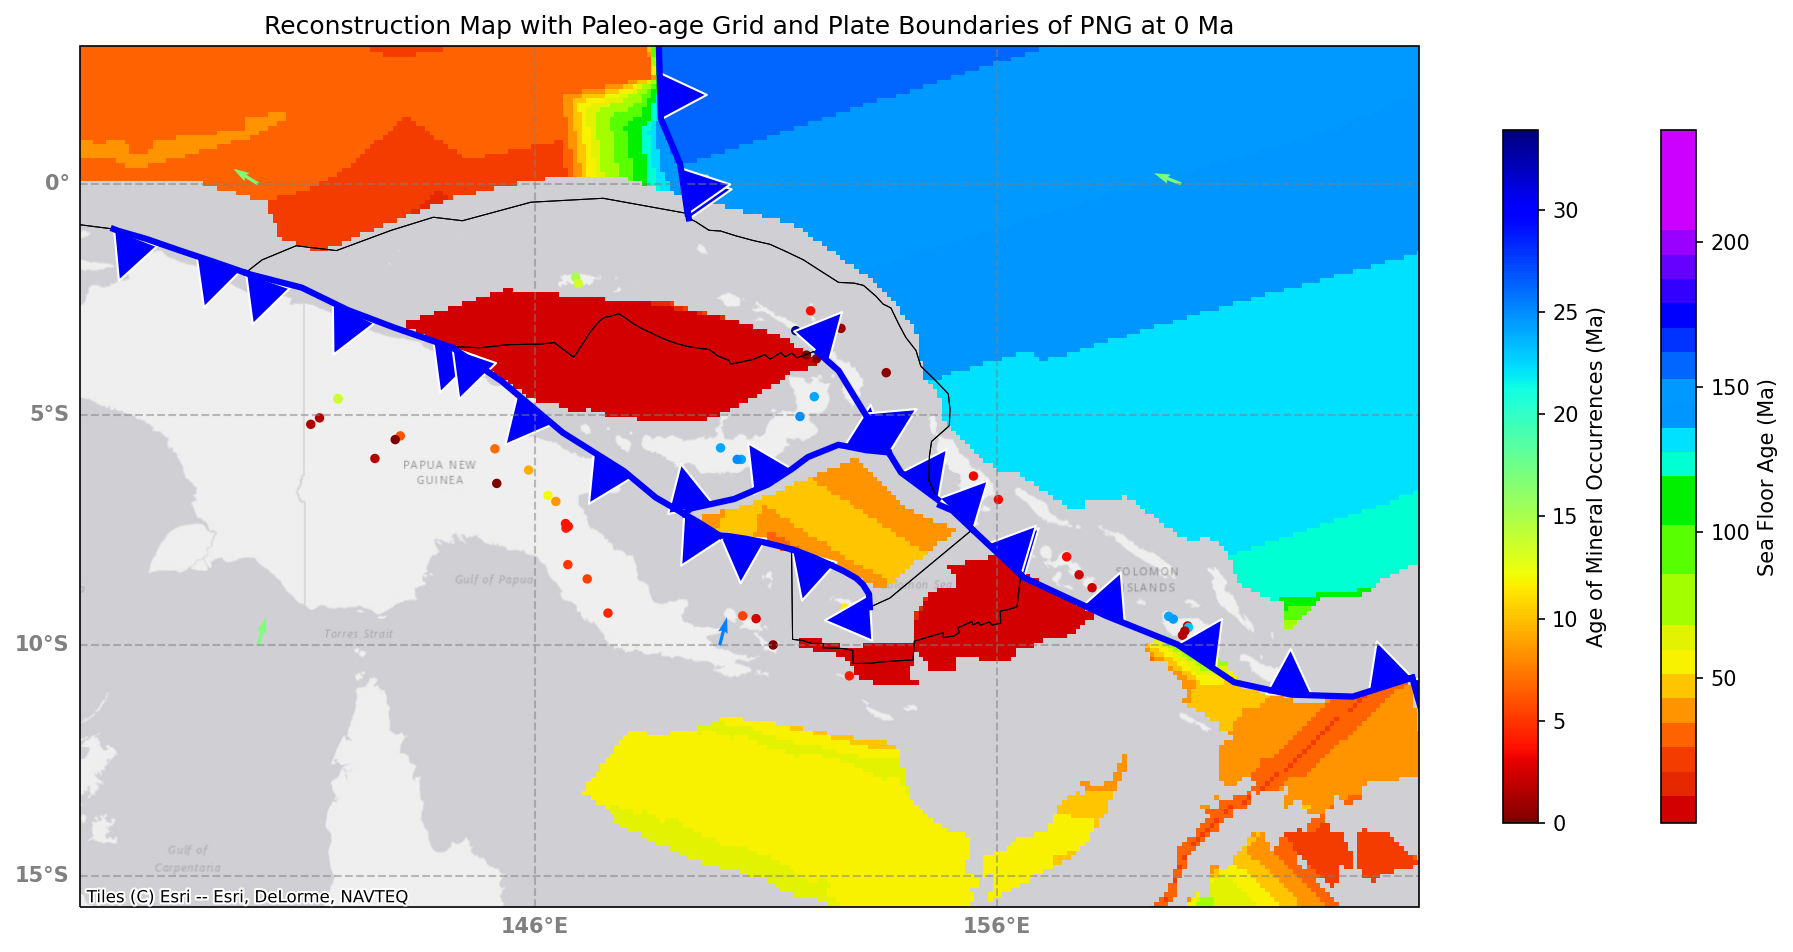

In [6]:
draw_velocity_vectors = True

# plot the map
fig = plt.figure(figsize=(16, 12), dpi=150)
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=0))
set_ax(ax, min_occ_extent, 10, 5, stock_img=False)
cx.add_basemap(ax, crs='EPSG:4326', source=cx.providers.Esri.WorldGrayCanvas)

if agegrid_file:
    img = Dataset(agegrid_file) # age grid
    cb1 = ax.imshow(img.variables['z'], origin='lower', transform=ccrs.PlateCarree(),
                   extent=global_extent, cmap=agegrid_cmap)

# plot topological plate boundaries
for t in resolved_topologies:
    lat, lon = zip(*(t.get_resolved_boundary().to_lat_lon_list()))
    plt.plot(lon, lat,
             color='black', linewidth=0.5,
             transform=ccrs.Geodetic()
            )

# plot subduction zones
for geom, aspect in subduction_geoms:
    lat, lon = zip(*(geom.to_lat_lon_list()))
    plt.plot(lon, lat,
             color='blue', linewidth=3,
             transform=ccrs.Geodetic()
            )
    teeth = Utils.get_subduction_teeth(lon, lat, triangle_aspect=aspect)
    for tooth in teeth:
        ring = LinearRing(tooth)
        ax.add_geometries([ring], ccrs.PlateCarree(), facecolor='blue', edgecolor='white', alpha=1)

if draw_velocity_vectors:
    # draw velocity vectors
    # some arrows are long and some are very short. To make the plot clearer, we nomalize the velocity magnitude
    # and use color to denote magnitudes
    u = np.array(u)
    v = np.array(v)
    mag = np.sqrt(u*u+v*v)
    u = u/mag
    v = v/mag
    ax.quiver(x, y, u, v, mag, transform=ccrs.PlateCarree(), cmap='jet')

cb2 = ax.scatter(min_lons, min_lats, 50, marker='.', c=min_age, cmap=plt.cm.jet_r)

if agegrid_file:
    plt.title(f'Reconstruction Map with Paleo-age Grid and Plate Boundaries of PNG at {time} Ma')
    fig.colorbar(cb1, shrink=0.5, label='Sea Floor Age (Ma)', pad=-0.05)
    fig.colorbar(cb2, shrink=0.5, label='Age of Mineral Occurrences (Ma)', pad=0.05)
else:
    plt.title(f'Reconstruction Map of PNG with Plate Boundaries at {time} Ma')
    fig.colorbar(cb2, shrink=0.5, label='Age of Mineral Occurrences (Ma)')

plt.show()

  0%|          | 0/24 [00:00<?, ?it/s]

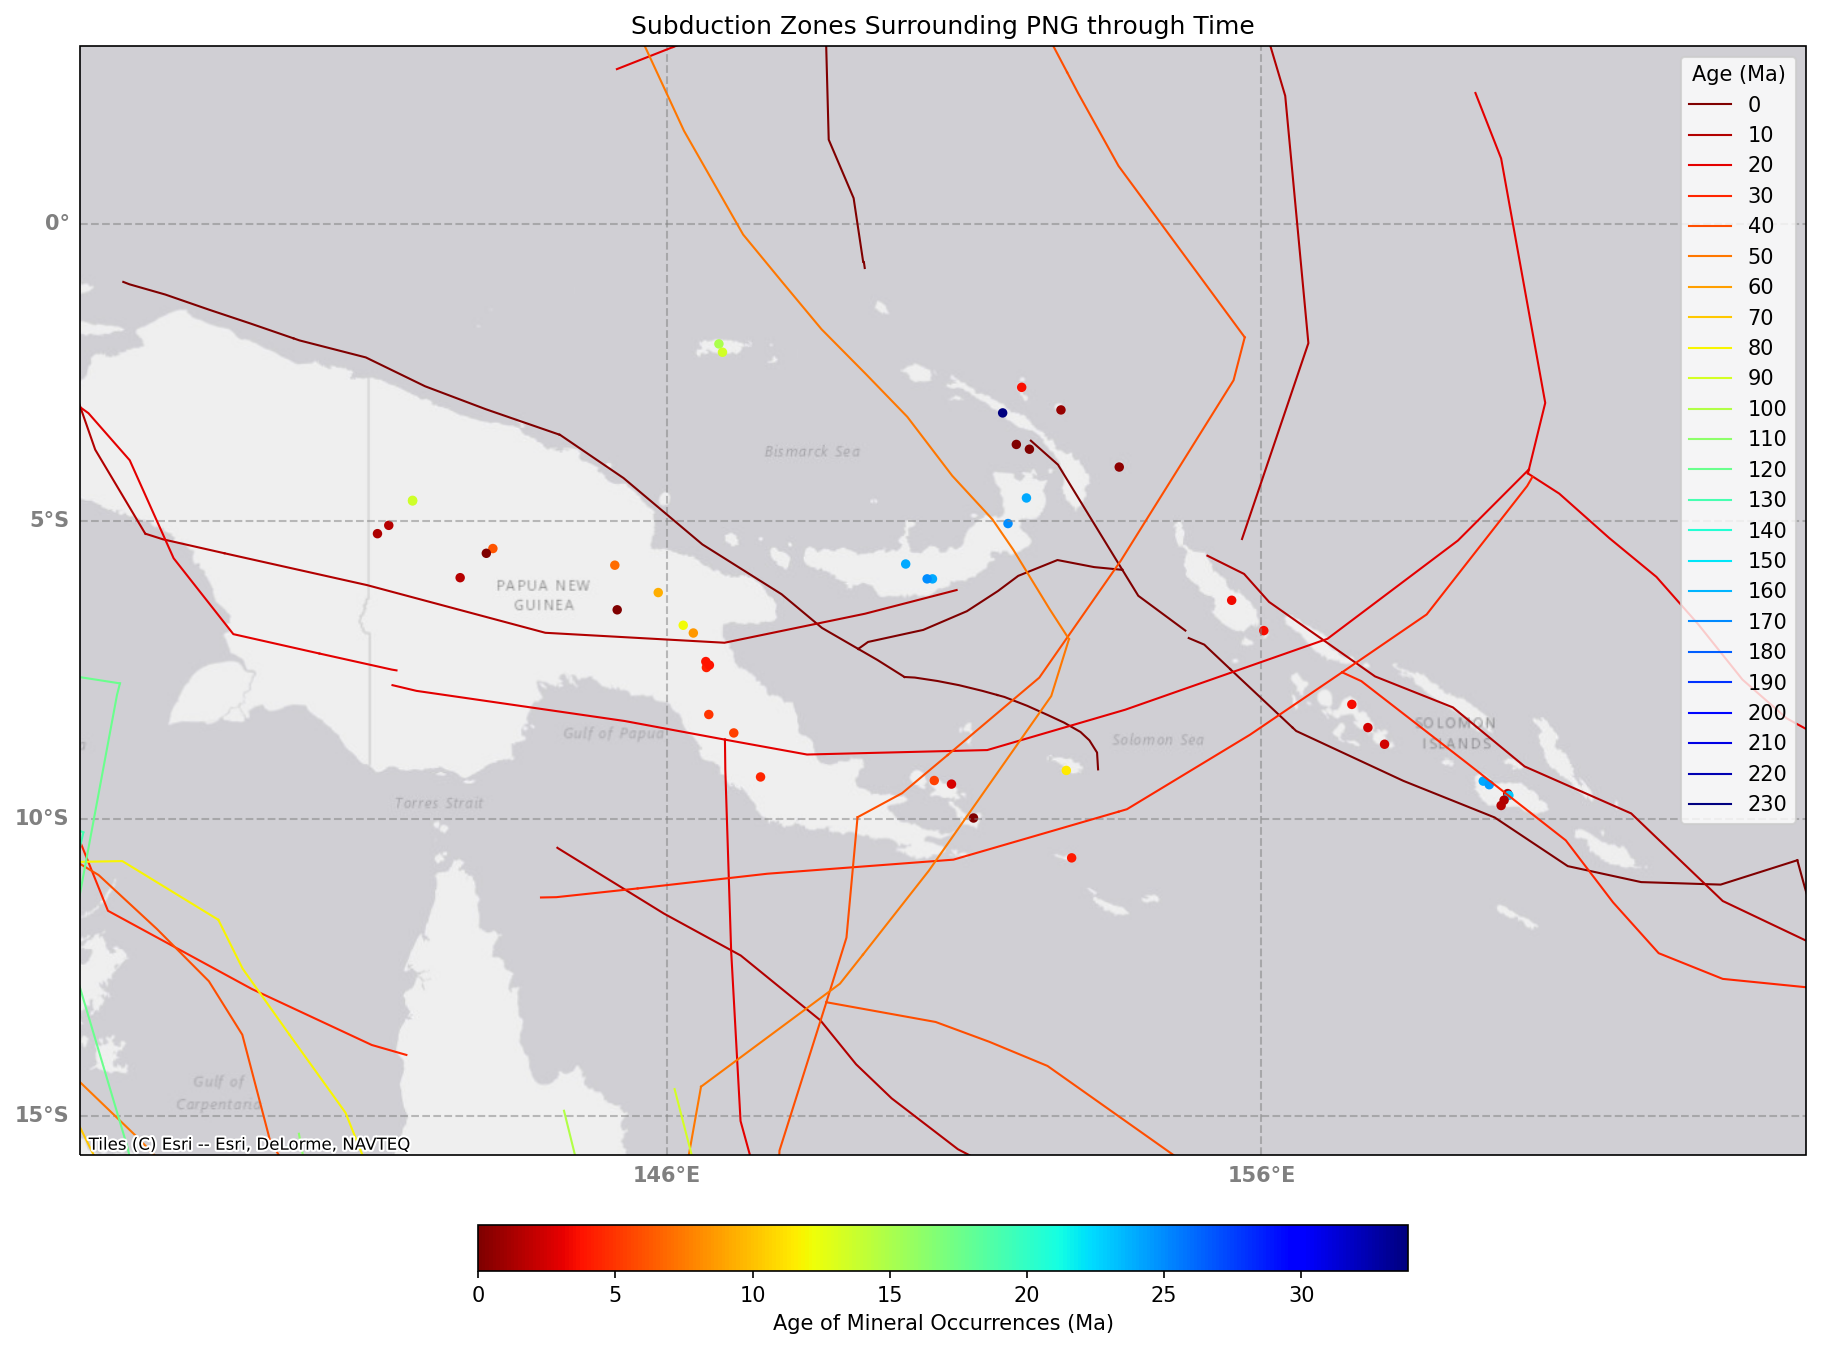

In [7]:
# get start time, end time, and time step from parameters.py
time_period = Utils.get_parameter('time')
start_time = time_period['start'] 
end_time = time_period['end']
time_step = time_period['step']
time_steps = list(range(start_time, end_time+1, time_step))

# plot the map
fig = plt.figure(figsize=(16, 12), dpi=150)
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=0))
set_ax(ax, min_occ_extent, 10, 5, stock_img=False)
cx.add_basemap(ax, crs='EPSG:4326', source=cx.providers.Esri.WorldGrayCanvas)

colors = plt.cm.jet_r(np.linspace(0, 1, len(range(start_time, end_time+1, 10))))

for time, color in tqdm(zip(range(start_time, end_time+1, 10), colors), total=len(colors)):
    resolved_topologies = []
    shared_boundary_sections = []
    # use pygplates to resolve the topologies
    pygplates.resolve_topologies(topology_files, rotation_files, resolved_topologies, time, shared_boundary_sections)

    # subduction zones
    subduction_geoms = []
    Utils.get_subduction_geometries(subduction_geoms, shared_boundary_sections)
    
    # plot subduction zones
    for geom, aspect in subduction_geoms:
        lat, lon = zip(*(geom.to_lat_lon_list()))
        plt.plot(lon, lat,
                 color=color, linewidth=1,
                 transform=ccrs.Geodetic(), label=time)

cb = ax.scatter(min_lons, min_lats, 50, marker='.', c=min_age, cmap=plt.cm.jet_r)
fig.colorbar(cb, shrink=0.5, label='Age of Mineral Occurrences (Ma)', pad=0.05, location='bottom')

# remove duplicates from the legend 
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), title='Age (Ma)', loc='upper right')

plt.title('Subduction Zones Surrounding PNG through Time')

plt.show()

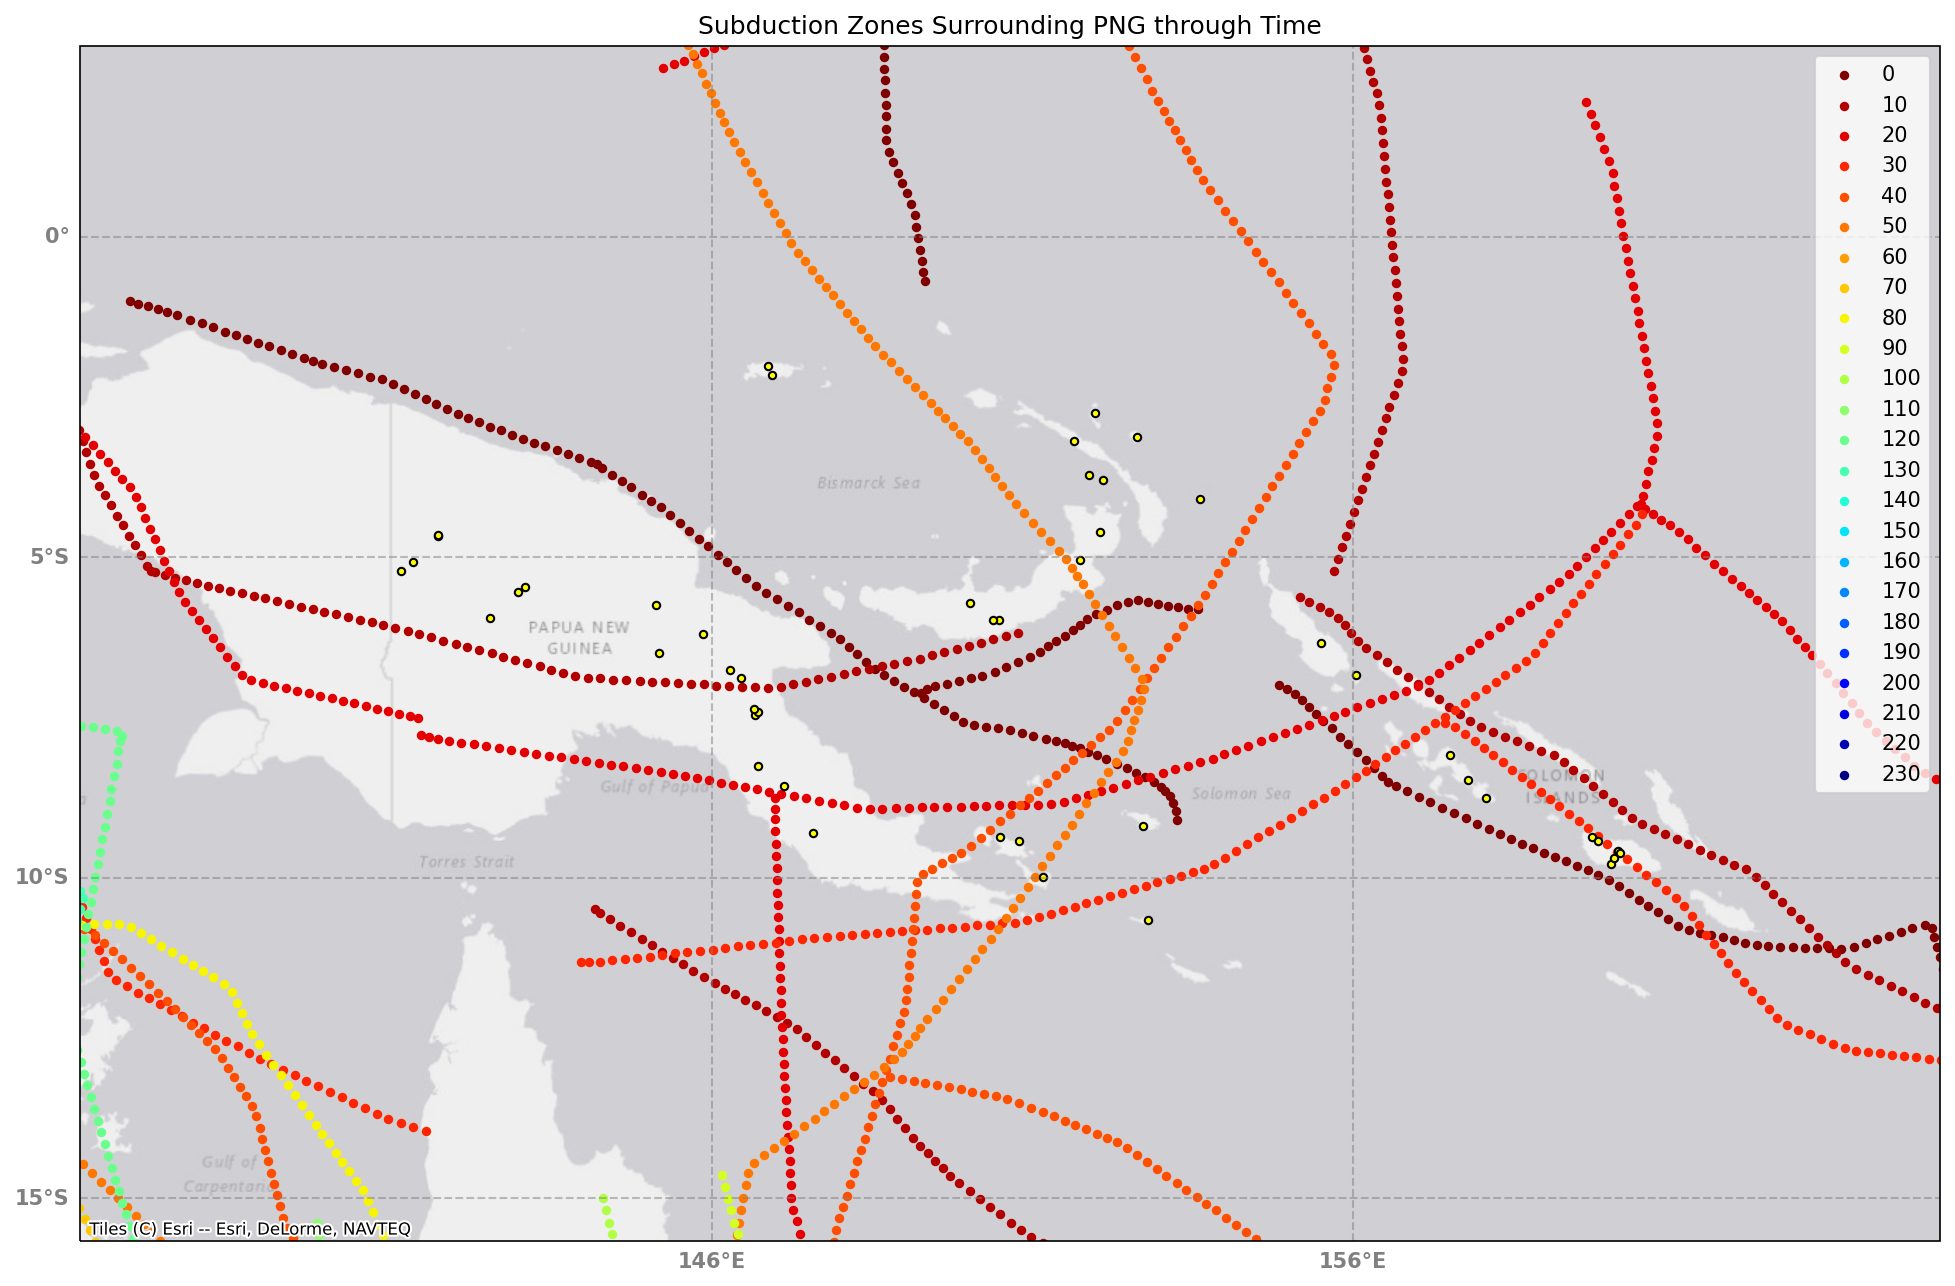

In [8]:
# plot the map
fig = plt.figure(figsize=(16, 12), dpi=150)
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=0))
set_ax(ax, min_occ_extent, 10, 5, stock_img=False)
cx.add_basemap(ax, crs='EPSG:4326', source=cx.providers.Esri.WorldGrayCanvas)

colors = plt.cm.jet_r(np.linspace(0, 1, len(range(start_time, end_time+1, 10))))

for time, color in zip(range(start_time, end_time+1, 10), colors):
    trench_data = Utils.get_trench_points(time)
    ax.scatter(trench_data['trench_lon'], trench_data['trench_lat'], 50, marker='.', c=color.reshape(1,-1), label=time)

ax.scatter(min_lons, min_lats, 50, marker='.', color='yellow', edgecolor='black')

ax.legend(loc='upper right')

plt.title('Subduction Zones Surrounding PNG through Time')

plt.show()

# Mineral Occurrences

In [9]:
min_occ_data_file = Utils.get_coreg_input_dir() + Utils.get_parameter('coreg_input_files')[0] # returns 'mineral_occurrences'

if os.path.isfile(min_occ_data_file):
    min_occ_data = pd.read_csv(min_occ_data_file, index_col=False)
else:
    # id, lon, lat, age, and plate id of mineral occurrences
    min_occ_data = process_real_deposits(min_occ_path, start_time, end_time, time_step)

    # save the attributes of mineral occurrences
    min_occ_data = pd.DataFrame(min_occ_data, columns=['index', 'lon', 'lat', 'age', 'plate_id'])
    min_occ_data = min_occ_data.astype({'index': int, 'lon': float, 'lat': float, 'plate_id': int, 'age': int})
    min_occ_data.to_csv(min_occ_data_file, index=False)

In [10]:
conv_file_prefix = Utils.get_parameter('convergence_data_filename_prefix')

@interact(time=time_steps)
def show_map(time):
    trench_file = Utils.get_convergence_dir() + f'{conv_file_prefix}_{time}.00.csv'
    trench_data = np.genfromtxt(trench_file, skip_header=1, delimiter=',')
    
    fig = plt.figure(figsize=(16, 12), dpi=150)
    ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=0))
    set_ax(ax, min_occ_extent, 10, 5, stock_img=False)
    cx.add_basemap(ax, crs='EPSG:4326', source=cx.providers.Esri.WorldGrayCanvas)

    cb = ax.scatter(min_occ_data['lon'], min_occ_data['lat'], 50, marker='.', c=min_occ_data['age'], cmap=plt.cm.jet_r)
    ax.scatter(trench_data[:, 0], trench_data[:, 1], 5, marker='.', color='black')
    ax.title.set_text('PNG Copper Deposits Coloured By Age')
    cbar = fig.colorbar(cb, shrink=0.5, ax=ax, orientation='horizontal', pad=0.05)
    cbar.set_label('Age(Myr)', size=10)
    cbar.ax.tick_params(labelsize=7)
    plt.show()

interactive(children=(Dropdown(description='time', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, …

# Buffer Zones

In [11]:
buffer_zone_file_lst = []

for time in time_steps:
    buffer_zone_file_lst.append(Utils.get_coreg_input_dir() + 'buffer_zones/' + f'buffer_zone_{time}_Ma.shp')

for buffer_zone_file in buffer_zone_file_lst:
    if not os.path.isfile(buffer_zone_file):
        index = buffer_zone_file_lst.index(buffer_zone_file)
        
        resolved_topologies = []
        shared_boundary_sections = []
        # use pygplates to resolve the topologies
        pygplates.resolve_topologies(topology_files, rotation_files, resolved_topologies, time_steps[index], shared_boundary_sections)

        # subduction zones
        subduction_geoms = []
        Utils.get_subduction_geometries(subduction_geoms, shared_boundary_sections)

        _, buffer_zone = generate_buffer_zones(subduction_geoms, 3)
        buffer_zone.to_file(buffer_zone_file)

target_extent_file = Utils.get_parameter('target_extent_file')
target_extent_gdf = gpd.read_file(target_extent_file)
buffer_zone_lst = []
buffer_zone_clipped_lst = []

for buffer_zone_file in buffer_zone_file_lst:
    buffer_zone = gpd.read_file(buffer_zone_file)
    buffer_zone_clipped = buffer_zone.clip(target_extent_gdf)
    buffer_zone_lst.append(buffer_zone)
    buffer_zone_clipped_lst.append(buffer_zone_clipped)

In [12]:
@interact(time=time_steps)
def show_map(time):
    resolved_topologies = []
    shared_boundary_sections = []
    # use pygplates to resolve the topologies
    pygplates.resolve_topologies(topology_files, rotation_files, resolved_topologies, time, shared_boundary_sections)

    # subduction zones
    subduction_geoms = []
    Utils.get_subduction_geometries(subduction_geoms, shared_boundary_sections)
    
    fig = plt.figure(figsize=(16, 12), dpi=150)
    ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=0))
    set_ax(ax, global_extent, 30, 15, stock_img=False)
    cx.add_basemap(ax, crs='EPSG:4326', source=cx.providers.Esri.WorldGrayCanvas)
    
    # subduction zones
    # plot subduction zones
    for geom, aspect in subduction_geoms:
        lat, lon = zip(*(geom.to_lat_lon_list()))
        plt.plot(lon, lat,
                 color='blue', linewidth=1,
                 transform=ccrs.Geodetic())

    buffer_zone_lst[time_steps.index(time)].plot(ax=ax, edgecolor='black', color='none', linewidth=1)
    
    ax.title.set_text(f'Buffer Zones Surrounding Subduction Zones at {time} Ma')
    plt.show()

interactive(children=(Dropdown(description='time', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, …

In [13]:
target_extent_bounds = target_extent_gdf.bounds
target_extent = [target_extent_bounds.loc[0]['minx'], target_extent_bounds.loc[0]['maxx'],
                 target_extent_bounds.loc[0]['miny'], target_extent_bounds.loc[0]['maxy']]

if target_extent[0] < -180:
    target_extent[0] = -180
if target_extent[1] > 180:
    target_extent[1] = 180
if target_extent[2] < -90:
    target_extent[2] = -90
if target_extent[3] > 90:
    target_extent[3] = 90
    
mpl.rcParams.update(mpl.rcParamsDefault)

@interact(time=time_steps)
def show_map(time):
    fig = plt.figure(figsize=(8, 6), dpi=100)
    ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=0))
    set_ax(ax, target_extent, 30, 15, stock_img=False)
    cx.add_basemap(ax, crs='EPSG:4326', source=cx.providers.Esri.WorldGrayCanvas)
    cb = ax.scatter(min_occ_data['lon'], min_occ_data['lat'], 10, marker='.', c=min_occ_data['age'], cmap=plt.cm.jet)
    buffer_zone_clipped_lst[time_steps.index(time)].plot(ax=ax, edgecolor='black', color='none', linewidth=0.5)
    ax.title.set_text(f'Buffer Zones Surrounding Subduction Zones at {time} Ma')
    # ax.set_title(f'Buffer Zones Surrounding Target Subduction Zones at {time} Ma', fontsize=10)
    cbar = fig.colorbar(cb, shrink=1, ax=ax, pad=0.05)
    cbar.set_label('Age of Mineral Occurrences (Ma)', size=10)
    cbar.ax.tick_params(labelsize=7)
    plt.show()

interactive(children=(Dropdown(description='time', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, …

# Random Samples

In [18]:
# if the calculated number of samples per time step is less than one, the code uniformly distributes samples through time
time_steps_random = time_steps
random_data_file = Utils.get_coreg_input_dir() + Utils.get_parameter('coreg_input_files')[1]

if os.path.isfile(random_data_file):
    random_data = pd.read_csv(random_data_file, index_col=False)
    time_steps_random = random_data['age'].tolist()
else:
    num_features = len(Utils.get_parameter('selected_features'))
    num_rand_samples = 5 * num_features
    num_time_steps = ((end_time - start_time) / time_step) + 1
    num_rand_samples_step = round(num_rand_samples / num_time_steps)
    if num_rand_samples_step < 1:
        num_rand_samples_step = 1
        time_steps_random = np.random.random_integers(start_time, end_time, num_rand_samples).tolist()

    random_data_lst = []
    rand_factor = 20

    for time in tqdm(time_steps_random):
        # generate random samples and extract id, lon, lat, age, and plate id
        random_data = generate_random_samples(buffer_zone_clipped_lst[time_steps.index(time)],
                                              time, num_rand_samples_step, rand_factor)
        random_data_lst.append(random_data)

    # save the attributes of random samples
    random_data = np.vstack(random_data_lst)
    index_lst = list(range(random_data.shape[0]))
    index_lst = np.array(index_lst).reshape(-1, 1)
    random_data = np.hstack([index_lst, random_data])
    random_data = pd.DataFrame(random_data, columns=['index', 'lon','lat','age','plate_id'])
    random_data = random_data.astype({'index': int, 'lon': float, 'lat': float, 'plate_id': int, 'age': int})
    random_data.to_csv(random_data_file, index=False)

In [19]:
time_steps_random_sorted = sorted(time_steps_random)
time_steps_random_sorted = [*set(time_steps_random_sorted)]

@interact(time=time_steps_random_sorted)
def show_map(time):
    fig = plt.figure(figsize=(8, 6), dpi=100)
    ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=0))
    set_ax(ax, target_extent, 30, 15, stock_img=False)
    cx.add_basemap(ax, crs='EPSG:4326', source=cx.providers.Esri.WorldGrayCanvas)
    cb = ax.scatter(min_occ_data['lon'], min_occ_data['lat'], 50, marker='.', c=min_occ_data['age'], cmap=plt.cm.jet)
    buffer_zone_clipped_lst[time_steps.index(time)].plot(ax=ax, edgecolor='black', color='none', linewidth=0.5)
    random_samples = random_data.loc[random_data['age'] == time]
    ax.scatter(random_samples['lon'], random_samples['lat'], 100, marker='*', color='red')
    ax.title.set_text(f'Buffer Zones Surrounding Subduction Zones at {time} Ma')
    cbar = fig.colorbar(cb, shrink=1, ax=ax, pad=0.05)
    cbar.set_label('Age of Mineral Occurrences (Ma)', size=10)
    cbar.ax.tick_params(labelsize=7)
    plt.show()

interactive(children=(Dropdown(description='time', options=(1, 3, 4, 5, 6, 9, 10, 11, 12, 16, 17, 20, 21, 22, …

# Target Points

In [20]:
target_points_in_file_lst = []
mask_coords_file_lst = []

for time in time_steps:
    target_points_in_file_lst.append(Utils.get_coreg_input_dir() +
                                  Utils.get_parameter('coreg_input_files')[2] +
                                  f'_{time}_Ma.csv')
    mask_coords_file_lst.append(Utils.get_coreg_input_dir() + f'mask_{time}_Ma.csv')

for target_points_file, mask_coords_file in zip(target_points_in_file_lst, mask_coords_file_lst):
    if not(os.path.isfile(target_points_file) and os.path.isfile(mask_coords_file)):
        dist_x = 1
        dist_y = 1
        index = target_points_in_file_lst.index(target_points_file)

        # generate target points
        target_points, mask_coords, nx, ny = generate_samples(buffer_zone_clipped_lst[index], dist_x, dist_y, time_steps[index])

        # save the attributes of target points
        target_points = pd.DataFrame(target_points, columns=['index', 'lon','lat','age','plate_id'])
        target_points = target_points.astype({'index': int, 'lon': float, 'lat': float, 'plate_id': int, 'age': int})
        target_points.to_csv(target_points_file, index=False)

        # save the mask
        mask_coords = pd.DataFrame(mask_coords, columns=['lon','lat', 'include'])
        mask_coords.to_csv(mask_coords_file, index=False)

target_points_in_lst = []
mask_coords_lst = []

for target_points_file, mask_coords_file in zip(target_points_in_file_lst, mask_coords_file_lst):
    target_points_in_lst.append(pd.read_csv(target_points_file, index_col=False))
    mask_coords_lst.append(pd.read_csv(mask_coords_file, index_col=False))

In [21]:
@interact(time=time_steps)
def show_map(time):
    fig = plt.figure(figsize=(8, 6), dpi=100)
    ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=0))
    set_ax(ax, target_extent, 30, 15, stock_img=False)
    cx.add_basemap(ax, crs='EPSG:4326', source=cx.providers.Esri.WorldGrayCanvas)
    buffer_zone_clipped_lst[time_steps.index(time)].plot(ax=ax, edgecolor='black', color='none', linewidth=0.5)    
    # target points
    ax.scatter(target_points_in_lst[time_steps.index(time)]['lon'],
               target_points_in_lst[time_steps.index(time)]['lat'],
               5, marker='.', color='red')
    ax.title.set_text(f'Target Points Inside Buffer Zones Surrounding Subduction Zones at {time} Ma')
    plt.show()

interactive(children=(Dropdown(description='time', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, …

# Coregistration and Data Wrangling

In [22]:
coreg_out_dir = Utils.get_coreg_output_dir()
positive_data_file = coreg_out_dir + '/' + Utils.get_parameter('coreg_input_files')[0]
unlabelled_data_file = coreg_out_dir + '/' + Utils.get_parameter('coreg_input_files')[1]

target_points_out_file_lst = []
for time in time_steps:
    target_points_out_file_lst.append(coreg_out_dir +
                                  Utils.get_parameter('coreg_input_files')[2] +
                                  f'_{time}_Ma.csv')

if os.path.isfile(positive_data_file) and os.path.isfile(unlabelled_data_file)\
and all([os.path.isfile(file) for file in target_points_out_file_lst]):
    positive_data = pd.read_csv(positive_data_file)
    unlabelled_data = pd.read_csv(unlabelled_data_file)
    target_points_out_lst = []
    for file_name in target_points_out_file_lst:
        target_points_out_lst.append(pd.read_csv(file_name))
else:
    # run the coregistration script
    coregistration.run()
    positive_data = pd.read_csv(positive_data_file)
    unlabelled_data = pd.read_csv(unlabelled_data_file)
    target_points_out_lst = []
    for file_name in target_points_out_file_lst:
        target_points_out_lst.append(pd.read_csv(file_name))

In [23]:
positive_data['label'] = 1
unlabelled_data['label'] = 0

positive_features = positive_data[Utils.get_parameter('selected_features')]
unlabelled_features = unlabelled_data[Utils.get_parameter('selected_features')]

# impute the missing values of unlabelled observations using iterative imputer
# explicitly require this experimental feature
from sklearn.experimental import enable_iterative_imputer  # noqa
# now you can import normally from sklearn.impute
from sklearn.impute import IterativeImputer

iter_imputer = IterativeImputer(initial_strategy='most_frequent', random_state=1)
unlabelled_features_imputed = pd.DataFrame(iter_imputer.fit_transform(unlabelled_features), columns=unlabelled_features.columns)

features_all = pd.concat([positive_features, unlabelled_features_imputed]).reset_index(drop=True)

target_points_features = []
for df in target_points_out_lst:
    target_points_features_temp = df[Utils.get_parameter('selected_features')]
    iter_imputer = IterativeImputer(initial_strategy='most_frequent', random_state=1)
    target_points_features_imputed = pd.DataFrame(iter_imputer.fit_transform(target_points_features_temp),
                                                  columns=target_points_features_temp.columns)
    target_points_features.append(target_points_features_imputed)

positive_labels = positive_data[positive_data.columns[-1]]
unlabelled_labels = unlabelled_data[unlabelled_data.columns[-1]]
labels = pd.concat([positive_labels, unlabelled_labels]).reset_index(drop=True)
features_labels_original = pd.concat([features_all, labels], axis=1).reset_index(drop=True)

# drop highly correlated features
# create a correlation matrix
corr_matrix = features_all.corr(method='spearman').abs()
# select the upper triangle of the correlation matrix
corr_upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
# find features with the correlation greater than 0.7
corr_drop = [column for column in corr_upper.columns if any(corr_upper[column] > 0.7)]
# drop features
features = features_all.drop(corr_drop, axis=1)
features_list = features.columns.tolist()

scaler = StandardScaler()
features = scaler.fit_transform(features)
features = pd.DataFrame(features, columns=features_list)
features_labels = pd.concat([features, labels], axis=1).reset_index(drop=True)

print('Number of positive samples:', positive_features.shape[0])
print('Number of unlabelled samples:', unlabelled_features_imputed.shape[0])
print('Number of features:', features.shape[1])

for i, df in enumerate(target_points_features):
    df_modified = df[df.columns.intersection(features.columns)]
    scaler = StandardScaler()
    df_modified = scaler.fit_transform(df_modified.to_numpy())
    df_modified = pd.DataFrame(df_modified, columns=features_list)
    target_points_features[i] = df_modified

# save the data
ml_input_dir = Utils.get_ml_input_dir()

if not os.path.isdir(ml_input_dir):
    os.mkdir(ml_input_dir)

features_labels.to_csv(ml_input_dir + 'features_labels.csv', index=False)

for i, df in enumerate(target_points_features):
    df.to_csv(ml_input_dir + Utils.get_parameter('coreg_input_files')[2] + f'_{time_steps[i]}_Ma.csv', index=False)

corr = features_all.corr()
corr.style.background_gradient(cmap='coolwarm', axis=None).set_precision(2) # 'RdBu_r', 'BrBG_r', & PuOr_r are other good diverging colormaps

Number of positive samples: 47
Number of unlabelled samples: 110
Number of features: 14


# Machine Learning

In [24]:
# generate a confusion matrix
def print_cm(cm, labels, hide_zeroes=False, hide_diagonal=False, hide_threshold=None):
    '''pretty print for confusion matrixes'''
    columnwidth = max([len(x) for x in labels]) + 4
    empty_cell = ' ' * columnwidth
    print('    ' + empty_cell, end=' ')
    for label in labels:
        print('%{0}s'.format(columnwidth) % 'pred_' + label, end=' ')
    print()

    # Print rows
    for i, label1 in enumerate(labels):
        print('    %{0}s'.format(columnwidth) % 'true_' + label1, end=' ')
        for j in range(len(labels)):
            cell = '%{0}.1f'.format(columnwidth) % cm[i, j]
            if hide_zeroes:
                cell = cell if float(cm[i, j]) != 0 else empty_cell
            if hide_diagonal:
                cell = cell if i != j else empty_cell
            if hide_threshold:
                cell = cell if cm[i, j] > hide_threshold else empty_cell
            if cell:
                print(cell, end=' ')
        print()

# features_labels_pul = features_labels.sample(frac=1).reset_index(drop=True)
features_labels_pul = features_labels.sample(frac=1, random_state=1)
features_pul = features_labels_pul[features_labels_pul.columns[:-1]].copy()
labels_pul = features_labels_pul[features_labels_pul.columns[-1]].copy()

# hide 30 percent of the samples labelled one
hidden_size = round(0.3 * (labels_pul==1).sum())

labels_pul_training = labels_pul.copy()
np.random.seed(1)
rand_ind = np.random.choice(labels_pul_training[labels_pul_training==1].index, replace=False, size=hidden_size)
labels_pul_training.loc[rand_ind] = 0

# Random Forest model structure
rf = RandomForestClassifier(n_jobs=-1, random_state=1)

print('Parameters currently in use:\n')
pprint(rf.get_params())

# n_estimators: number of trees in the foreset
# max_features: max number of features considered for splitting a node
# max_depth: max number of levels in each decision tree
# min_samples_split: min number of data points placed in a node before the node is split
# min_samples_leaf: min number of data points allowed in a leaf node
# bootstrap: method for sampling data points (with or without replacement)

rf.fit(features_pul, labels_pul_training)

print('')
print('---- {} ----'.format('Standard Random Forest'))
print(print_cm(sklearn.metrics.confusion_matrix(labels_pul, rf.predict(features_pul)), labels=['negative', 'positive']))
print('')
print('Precision: ', precision_score(labels_pul, rf.predict(features_pul)))
print('Recall: ', recall_score(labels_pul, rf.predict(features_pul)))
print('Accuracy: ', accuracy_score(labels_pul, rf.predict(features_pul)))
print('F1 score: ', f1_score(labels_pul, rf.predict(features_pul)))
print('ROC AUC score: ', roc_auc_score(labels_pul, rf.predict(features_pul)))

Parameters currently in use:

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': -1,
 'oob_score': False,
 'random_state': 1,
 'verbose': 0,
 'warm_start': False}

---- Standard Random Forest ----
                        pred_negative        pred_positive 
           true_negative        110.0          0.0 
           true_positive         14.0         33.0 
None

Precision:  1.0
Recall:  0.7021276595744681
Accuracy:  0.910828025477707
F1 score:  0.825
ROC AUC score:  0.851063829787234


In [25]:
# number of trees in the Random Forest
n_estimators = [int(x) for x in np.arange(20, 220, 20)]
# number of features to consider at every split
max_features = ['auto', 'sqrt', 'log2']
# maximum number of levels in each tree
max_depth = [int(x) for x in np.arange(10, 110, 10)]
max_depth.append(None)
# minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# method of selecting samples for training each tree
bootstrap = [True, False]
# create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
 'max_features': ['auto', 'sqrt', 'log2'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [20, 40, 60, 80, 100, 120, 140, 160, 180, 200]}


In [26]:
# use the random grid to search for best hyperparameters
# random search of hyperparameters using 10 fold cross validation
# search across 100 different combinations and use all available cores
rf_random = RandomizedSearchCV(estimator=rf, param_distributions=random_grid, n_iter=100,
                               cv=10, verbose=2, random_state=1, n_jobs=-1)

# fit the random search model
rf_random.fit(features_pul, labels_pul_training)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


RandomizedSearchCV(cv=10,
                   estimator=RandomForestClassifier(n_jobs=-1, random_state=1),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, None],
                                        'max_features': ['auto', 'sqrt',
                                                         'log2'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [20, 40, 60, 80, 100,
                                                         120, 140, 160, 180,
                                                         200]},
                   random_state=1, verbose=2)

In [27]:
# best set of hyperparameters
rf_random.best_params_

{'n_estimators': 100,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 30,
 'bootstrap': True}

In [28]:
# run the Random Forest classifier using the best set of hyperparameters
rf_random_best = rf_random.best_estimator_
rf_random_best.fit(features_pul, labels_pul_training)

print('---- {} ----'.format('Standard Random Forest'))
print(print_cm(sklearn.metrics.confusion_matrix(labels_pul, rf_random_best.predict(features_pul)), labels=['negative', 'positive']))
print('')
print('Precision: ', precision_score(labels_pul, rf_random_best.predict(features_pul)))
print('Recall: ', recall_score(labels_pul, rf_random_best.predict(features_pul)))
print('Accuracy: ', accuracy_score(labels_pul, rf_random_best.predict(features_pul)))
print('F1 score: ', f1_score(labels_pul, rf_random_best.predict(features_pul)))
print('ROC AUC score: ', roc_auc_score(labels_pul, rf_random_best.predict(features_pul)))

---- Standard Random Forest ----
                        pred_negative        pred_positive 
           true_negative        110.0          0.0 
           true_positive         14.0         33.0 
None

Precision:  1.0
Recall:  0.7021276595744681
Accuracy:  0.910828025477707
F1 score:  0.825
ROC AUC score:  0.851063829787234


In [29]:
# create the parameter grid based on the results of the random search
param_grid = {
    'bootstrap': [True],
    'max_depth': [2, 5, 10, 20],
    'max_features': ['auto'],
    'min_samples_leaf': [1, 2, 4],
    'min_samples_split': [2, 5, 10],
    'n_estimators': [20, 30, 40, 50]
}

# instantiate the grid search model
rf_grid = GridSearchCV(estimator=rf, param_grid=param_grid, cv=10, n_jobs=-1, verbose=2)

# fit the grid search
rf_grid.fit(features_pul, labels_pul_training)

Fitting 10 folds for each of 144 candidates, totalling 1440 fits


GridSearchCV(cv=10, estimator=RandomForestClassifier(n_jobs=-1, random_state=1),
             n_jobs=-1,
             param_grid={'bootstrap': [True], 'max_depth': [2, 5, 10, 20],
                         'max_features': ['auto'],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [20, 30, 40, 50]},
             verbose=2)

In [30]:
# best set of hyperparameters
rf_grid.best_params_

{'bootstrap': True,
 'max_depth': 10,
 'max_features': 'auto',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 50}

In [31]:
# run the Random Forest classifier using the best set of hyperparameters
rf_grid_best = rf_grid.best_estimator_
# rf_grid_best = RandomForestClassifier(n_estimators=50, min_samples_split=2, min_samples_leaf=4, max_features='auto',
#                                       max_depth=2, n_jobs=-1, random_state=1)
rf_grid_best.fit(features_pul, labels_pul_training)

print('---- {} ----'.format('Standard Random Forest'))
print(print_cm(sklearn.metrics.confusion_matrix(labels_pul, rf_grid_best.predict(features_pul)), labels=['negative', 'positive']))
print('')
print('Precision: ', precision_score(labels_pul, rf_grid_best.predict(features_pul)))
print('Recall: ', recall_score(labels_pul, rf_grid_best.predict(features_pul)))
print('Accuracy: ', accuracy_score(labels_pul, rf_grid_best.predict(features_pul)))
print('F1 score: ', f1_score(labels_pul, rf_grid_best.predict(features_pul)))
print('ROC AUC score: ', roc_auc_score(labels_pul, rf_grid_best.predict(features_pul)))

---- Standard Random Forest ----
                        pred_negative        pred_positive 
           true_negative        110.0          0.0 
           true_positive         14.0         33.0 
None

Precision:  1.0
Recall:  0.7021276595744681
Accuracy:  0.910828025477707
F1 score:  0.825
ROC AUC score:  0.851063829787234


In [32]:
bc = BaggingPuClassifier(rf_grid_best, n_estimators=20, max_samples=int(sum(labels_pul_training)), n_jobs=-1, random_state=1)
bc.fit(features_pul, labels_pul_training)

print('---- {} ----'.format('Bagging PU'))
print(print_cm(sklearn.metrics.confusion_matrix(labels_pul, bc.predict(features_pul)), labels=['negative', 'positive']))
print('')
print('Precision: ', precision_score(labels_pul, bc.predict(features_pul)))
print('Recall: ', recall_score(labels_pul, bc.predict(features_pul)))
print('Accuracy: ', accuracy_score(labels_pul, bc.predict(features_pul)))
print('F1 score: ', f1_score(labels_pul, bc.predict(features_pul)))
print('ROC AUC score: ', roc_auc_score(labels_pul, bc.predict(features_pul)))

---- Bagging PU ----
                        pred_negative        pred_positive 
           true_negative        106.0          4.0 
           true_positive          2.0         45.0 
None

Precision:  0.9183673469387755
Recall:  0.9574468085106383
Accuracy:  0.9617834394904459
F1 score:  0.9375000000000001
ROC AUC score:  0.9605415860735009


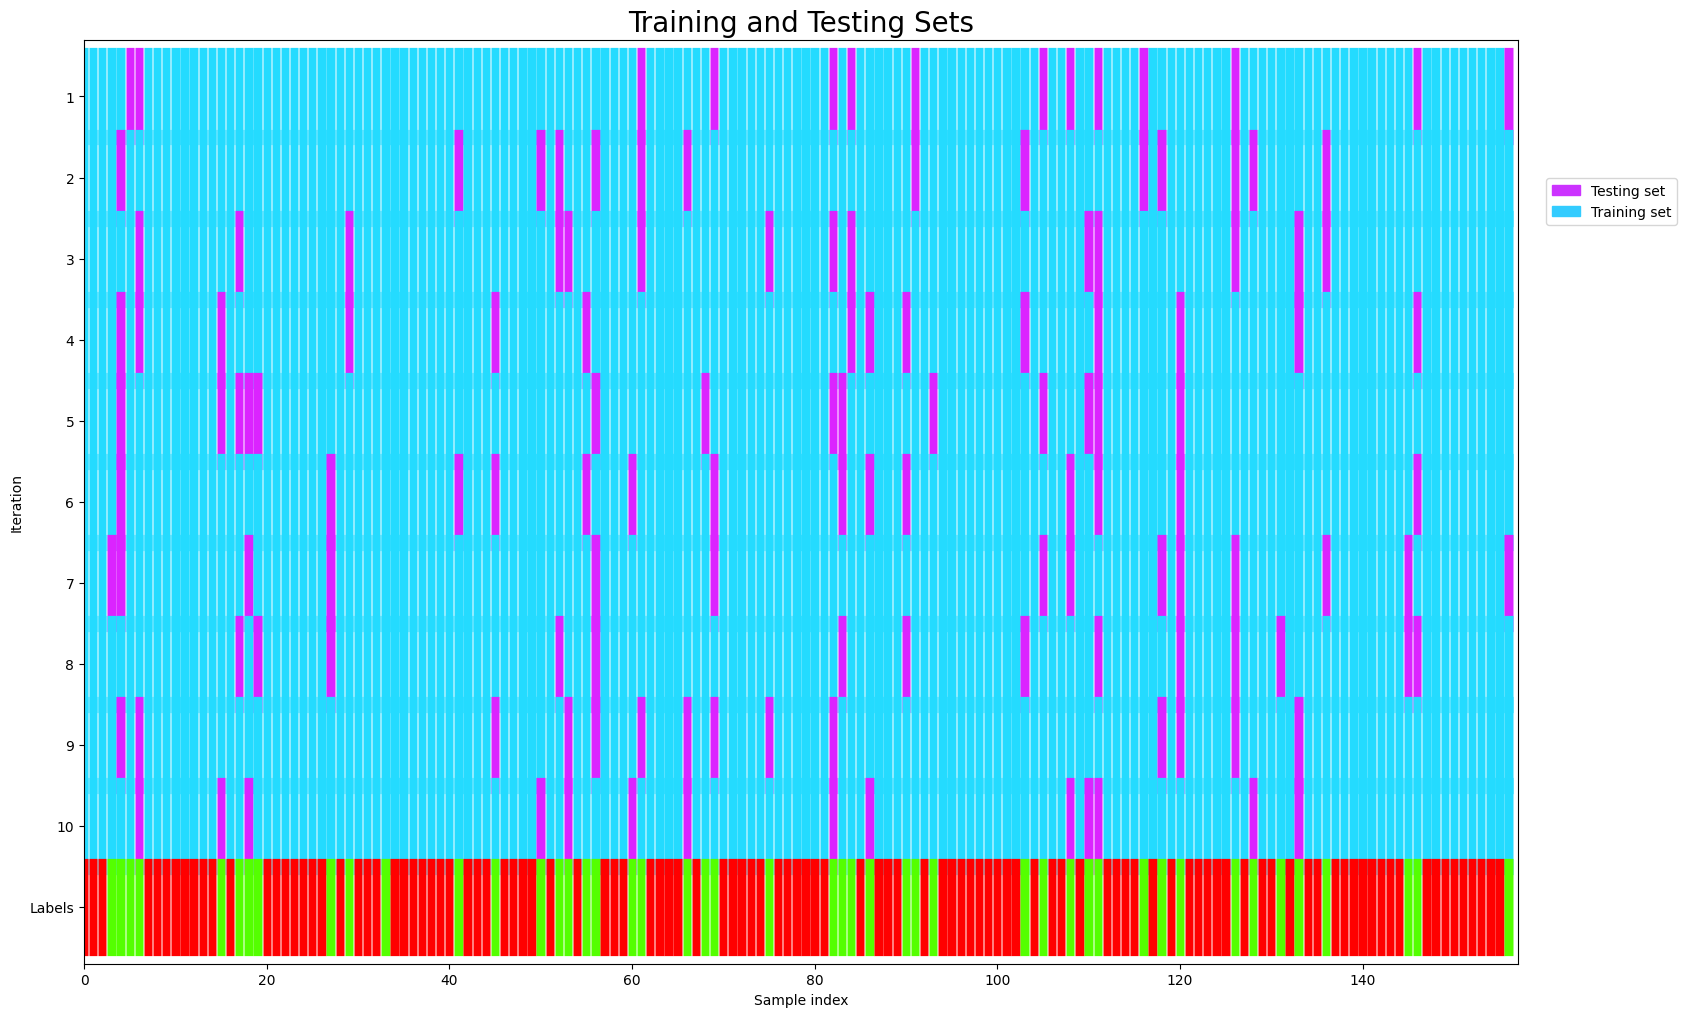

In [33]:
# generate different sets of training samples
iter_num = 10
labels_pul_training_all = np.empty((features_labels_pul.shape[0], iter_num))

# plt.rcParams.update({'font.size': 20})
fig, ax = plt.subplots()

np.random.seed(1)
for i in range(iter_num):
    # hide positive samples
    labels_pul_training = labels_pul.copy()
    labels_pul_training.loc[
        np.random.choice(
            labels_pul_training[labels_pul_training==1].index,
            replace=False,
            size=hidden_size
            )
        ] = 0
    
    labels_pul_training_all[:, i] = labels_pul_training
        
    # fill in indices with the training/testing groups
    indices = labels_pul - labels_pul_training

    # visualise the results
    ax.scatter(range(len(indices)), [i+.5]*len(indices),
                   c=indices, marker='_', lw=70, cmap='cool',
                   vmin=-.2, vmax=1.2)

# plot the data classes and groups at the end
ax.scatter(range(len(features_labels_pul)), [i+1.5]*len(features_labels_pul), c=labels_pul, marker='_', lw=70, cmap='prism')

n_splits = iter_num
yticklabels = list(range(1, n_splits+1)) + ['Labels']
ax.set(yticks=np.arange(n_splits+1)+0.5, yticklabels=yticklabels,
       xlabel='Sample index', ylabel='Iteration',
       ylim=[n_splits+1.2, -.2], xlim=[0, len(features_labels_pul)])
ax.set_title('Training and Testing Sets', fontsize=20)
ax.legend([Patch(color=plt.cm.cool(.8)), Patch(color=plt.cm.cool(.2))],
          ['Testing set', 'Training set'], loc=(1.02, .8))
fig.set_size_inches(18.5, 12)
plt.show()

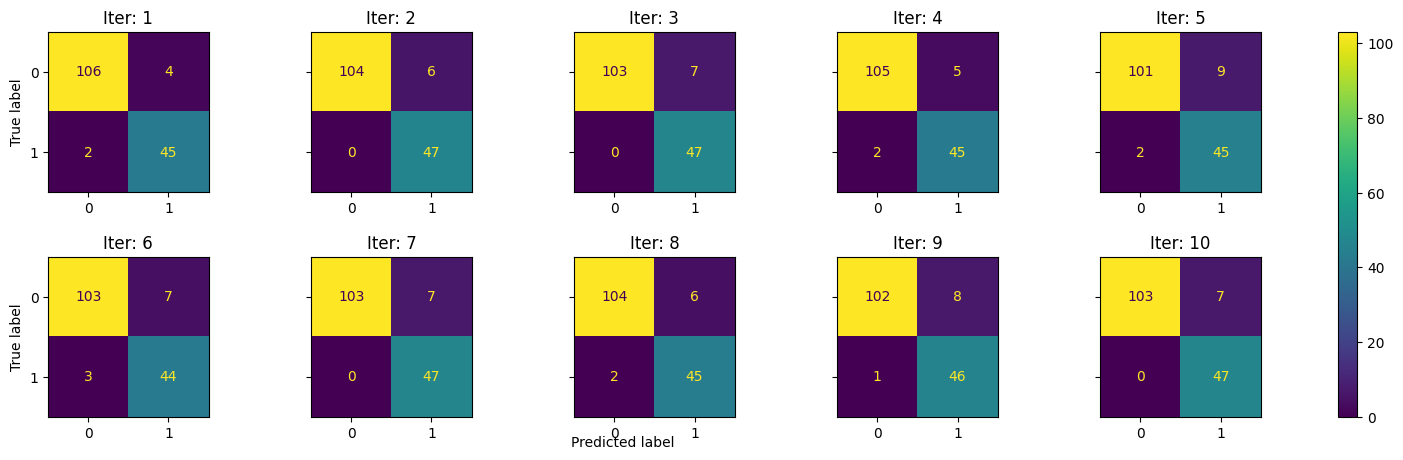

In [34]:
# confusion matrices for different sets of training and testing samples
# plt.rcParams.update({'font.size': 8})
f, axes = plt.subplots(2, 5, figsize=(20, 5), sharey='row')

j = 0
k = 0

for i in range(iter_num):
    # rf_grid_best.fit(features_pul, labels_pul_training_all[:, i])
    # pred = rf_grid_best.predict(features_pul)
    bc.fit(features_pul, labels_pul_training_all[:, i])
    pred = bc.predict(features_pul)
    
    cf_matrix = confusion_matrix(labels_pul, pred)
    disp = ConfusionMatrixDisplay(cf_matrix)
    disp.plot(ax=axes[j, k])
    disp.ax_.set_title('Iter: '+str(i+1))
    disp.im_.colorbar.remove()
    disp.ax_.set_xlabel('')
    if i!=0 and i!=5:
        disp.ax_.set_ylabel('')
    
    k += 1
    if i == 4:
        j = 1
        k = 0

f.text(0.4, 0.05, 'Predicted label', ha='left')
plt.subplots_adjust(wspace=0.4, hspace=0.4)
f.colorbar(disp.im_, ax=axes)
plt.show()

In [35]:
# run the classifier for ten times and take the average of feature importance values
importances = np.empty((len(features_list), iter_num))

for i in range(iter_num):
    bc.fit(features_pul, labels_pul_training_all[:, i])
    importances[:, i] = bc.base_estimator_.feature_importances_

importances_mean = importances.mean(axis=1)
importances_var = importances.var(axis=1)

feature_importances = [(feature, round(importance, 5)) for feature, importance in zip(features_list, importances_mean)]
feature_importances = sorted(feature_importances, key=lambda x:x[1], reverse=True)
[print('Feature: {:60} Importance: {}'.format(*pair)) for pair in feature_importances]

with open(f'feature_importance.csv', 'w', newline='') as f:
    writer = csv.writer(f)
    writer.writerows(feature_importances)

Feature: trench_abs_rate                                              Importance: 0.16454
Feature: distance                                                     Importance: 0.14795
Feature: conv_angle                                                   Importance: 0.08314
Feature: subducting_abs_angle                                         Importance: 0.0829
Feature: carbonate_sediment_thickness                                 Importance: 0.07718
Feature: subducting_abs_rate                                          Importance: 0.07659
Feature: dist_from_start                                              Importance: 0.06334
Feature: trench_abs_angle                                             Importance: 0.05955
Feature: seafloor_age                                                 Importance: 0.04995
Feature: conv_rate                                                    Importance: 0.04681
Feature: total_sediment_thick                                         Importance: 0.04606
Feature: di

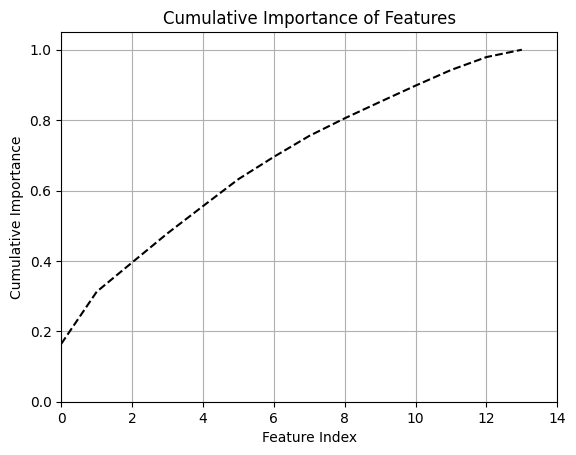

Number of features for 90% importance: 12


In [36]:
# list of features sorted from most to least important
sorted_importances = [importance[1] for importance in feature_importances]
sorted_features = [importance[0] for importance in feature_importances]
# cumulative importance
cumulative_importances = np.cumsum(sorted_importances)
# make a linear graph
x_values = list(range(len(feature_importances)))
plt.plot(x_values, cumulative_importances, 'k--')
# axis labels and title
plt.xlabel('Feature Index'); plt.ylabel('Cumulative Importance'); plt.title('Cumulative Importance of Features');
plt.grid()
plt.ylim(0, 1.05)
plt.xlim(0, len(feature_importances))
plt.show()

important_features_num = np.where(cumulative_importances > 0.9)[0][0]+1
print('Number of features for 90% importance:', important_features_num)

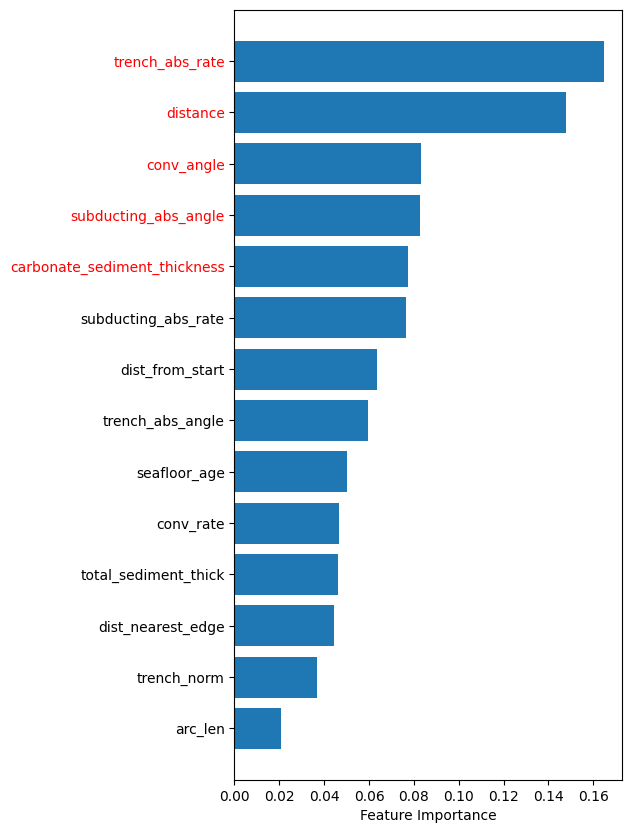

In [37]:
# print significant features above some threshold
feature_importances.sort(key=lambda x:x[1])

fig, ax = plt.subplots(figsize=(5, 10))

ft_imps = [x[1] for x in feature_importances]
y_pos = np.arange(len(feature_importances))
ax.barh(y_pos, ft_imps, align='center')
ax.set_ylim(-1, len(ft_imps))
ax.set_yticks(range(len(ft_imps)))
ax.set_yticklabels([x[0] for x in feature_importances])

# highlight top 5 features
for i in range(len(ft_imps)-5, len(ft_imps)):
    ax.get_yticklabels()[i].set_color('red')

ax.set_xlabel('Feature Importance')

plt.show()

In [38]:
def interactive_hist(df, columns, colorby='label'):
    @interact(x=columns)
    def update(x):
        fig = px.histogram(df, x=x, nbins=50, color=colorby, category_orders={'label': [0, 1]})
        fig.update_layout(xaxis=dict(title=x+' Values'),
                          yaxis=dict(title='Counts'),
                          title='Distribution Data - '+x,
                          barmode='stack', autosize=True,
                          width=800, height=600)
        fig.show('notebook')

labels_estimated = []
for pair in bc.oob_decision_function_:
    if np.isnan(pair[0]):
        labels_estimated.append(2)
    else:
        if pair[0] < pair[1]:
            labels_estimated.append(1)
        else:
            labels_estimated.append(0)

for i in range(len(labels_estimated)):
    if labels_estimated[i] == 2 and labels_pul.iloc[i] == 1:
        labels_estimated[i] = 1

df = features_labels_pul.copy()
df['label'] = labels_estimated
interactive_hist(df, df.columns)

interactive(children=(Dropdown(description='x', options=('distance', 'conv_rate', 'conv_angle', 'trench_abs_ra…

In [39]:
labels_pul_modified = labels_pul.copy()
labels_pul_modified = labels_pul_modified.to_frame()
labels_pul_modified['label_estimated'] = labels_estimated
labels_pul_modified.sort_index(inplace=True)
df_original = features_labels_original.copy()
df_original['label'] = labels_pul_modified['label_estimated']
interactive_hist(df_original, df_original.columns)

interactive(children=(Dropdown(description='x', options=('distance', 'conv_rate', 'conv_angle', 'trench_abs_ra…

In [40]:
target_points_prob_file_lst = []
target_points_prob_lst = []

for time in time_steps:
    target_points_prob_file_lst.append(Utils.get_ml_output_dir() + f'target_points_prob_{time}_Ma.csv')

for i, target_points_prob_file in tqdm(enumerate(target_points_prob_file_lst), total=len(target_points_prob_file_lst)):
    if not(os.path.isfile(target_points_prob_file)):
        df = target_points_features[target_points_prob_file_lst.index(target_points_prob_file)]
        # run the model for ten times using different sets of training samples and take the average of probability values for each target point
        probs = np.empty((df.shape[0], iter_num))

        for j in range(iter_num):
            bc.fit(features_pul, labels_pul_training_all[:, j])
            probs[:, j] = bc.predict_proba(df)[:, 1]

        # comment this section and uncomment the next one if interested to see original probability scores
        # --------------------
        scaler = MinMaxScaler()
        point_probs = scaler.fit_transform(probs)
        point_probs_mean = point_probs.mean(axis=1)
        point_probs_var = point_probs.var(axis=1)

        # --------------------
        # point_probs_mean = probs.mean(axis=1)
        # point_probs_var = probs.var(axis=1)

        df_xy = df.copy()
        df_xy['lon'] = target_points_out_lst[i]['lon'].to_numpy()
        df_xy['lat'] = target_points_out_lst[i]['lat'].to_numpy()
        df_xy['prob'] = point_probs_mean
        df_xy['var'] = point_probs_var
        df_xy.to_csv(target_points_prob_file, index=False)
        target_points_prob_lst.append(df_xy)
        
for target_points_prob_file in target_points_prob_file_lst:
    target_points_prob_lst.append(pd.read_csv(target_points_prob_file, index_col=False))

  0%|          | 0/231 [00:00<?, ?it/s]

### Probability

In [41]:
@interact(time=time_steps)
def show_map(time):
    plot_x = target_points_prob_lst[time_steps.index(time)]['lon']
    plot_y = target_points_prob_lst[time_steps.index(time)]['lat']

    # plot the probability map
    fig = plt.figure(figsize=(16, 12), dpi=150)
    ax = plt.axes(projection=ccrs.PlateCarree())
    set_ax(ax, target_extent, 10, 5, stock_img=False)
    cx.add_basemap(ax, crs='EPSG:4326', source=cx.providers.Esri.WorldGrayCanvas)
    
    cb = plt.scatter(plot_x, plot_y, 32., c=target_points_prob_lst[time_steps.index(time)]['prob'], cmap='Spectral_r')
    fig.colorbar(cb, shrink=0.5, label='Probability')
    plt.show()

interactive(children=(Dropdown(description='time', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, …

In [42]:
@interact(time=time_steps)
def show_map(time):
    # create a probability map using the target points
    traget_points = target_points_out_lst[time_steps.index(time)]
    mask_coords = mask_coords_lst[time_steps.index(time)]
    
    probabilities = []
    count = 0
            
    for mask in mask_coords['include']:
        if mask:
            probabilities.append(target_points_prob_lst[time_steps.index(time)]['prob'][count])
            count += 1
        else:
            probabilities.append(np.nan)
    
    nx = mask_coords_lst[time_steps.index(time)]['lon'].nunique()
    ny = mask_coords_lst[time_steps.index(time)]['lat'].nunique()
    
    x_min = mask_coords_lst[time_steps.index(time)]['lon'].min()
    x_max = mask_coords_lst[time_steps.index(time)]['lon'].max()
    y_min = mask_coords_lst[time_steps.index(time)]['lat'].min()
    y_max = mask_coords_lst[time_steps.index(time)]['lat'].max()
    
    probabilities_2d = np.reshape(probabilities, (ny, nx))
    probabilities_2d_ud = np.flipud(np.reshape(probabilities, (ny, nx)))
    
    fig = plt.figure(figsize=(16, 12), dpi=150)
    ax = plt.axes(projection=ccrs.PlateCarree())
    set_ax(ax, target_extent, 10, 5, stock_img=False)
    cx.add_basemap(ax, crs='EPSG:4326', source=cx.providers.Esri.WorldGrayCanvas)
    
    cb = plt.imshow(probabilities_2d, cmap='Spectral_r', origin='lower', interpolation='none',
               extent=(x_min, x_max, y_min, y_max))
    fig.colorbar(cb, shrink=0.5, label='Probability')
    plt.show()

interactive(children=(Dropdown(description='time', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, …

In [43]:
@interact(time=time_steps)
def show_map(time):
    # create a probability map using the target points
    traget_points = target_points_out_lst[time_steps.index(time)]
    mask_coords = mask_coords_lst[time_steps.index(time)]

    probabilities = []
    count = 0
            
    for mask in mask_coords['include']:
        if mask:
            probabilities.append(target_points_prob_lst[time_steps.index(time)]['prob'][count])
            count += 1
        else:
            probabilities.append(np.nan)
    
    nx = mask_coords_lst[time_steps.index(time)]['lon'].nunique()
    ny = mask_coords_lst[time_steps.index(time)]['lat'].nunique()
    
    x_min = mask_coords_lst[time_steps.index(time)]['lon'].min()
    x_max = mask_coords_lst[time_steps.index(time)]['lon'].max()
    y_min = mask_coords_lst[time_steps.index(time)]['lat'].min()
    y_max = mask_coords_lst[time_steps.index(time)]['lat'].max()
    
    probabilities_2d = np.reshape(probabilities, (ny, nx))
    probabilities_2d_ud = np.flipud(np.reshape(probabilities, (ny, nx)))
    
    fig = plt.figure(figsize=(16, 12), dpi=150)
    ax = plt.axes(projection=ccrs.PlateCarree())
    set_ax(ax, target_extent, 10, 5, stock_img=False)
    cx.add_basemap(ax, crs='EPSG:4326', source=cx.providers.Esri.WorldGrayCanvas)
    
    cb = plt.imshow(probabilities_2d, cmap='Spectral_r', origin='lower', interpolation='bilinear',
               extent=(x_min, x_max, y_min, y_max))
    fig.colorbar(cb, shrink=0.5, label='Probability')
    plt.show()

interactive(children=(Dropdown(description='time', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, …

### Variance

In [44]:
@interact(time=time_steps)
def show_map(time):
    plot_x = target_points_prob_lst[time_steps.index(time)]['lon']
    plot_y = target_points_prob_lst[time_steps.index(time)]['lat']

    # plot the variance map
    fig = plt.figure(figsize=(16, 12), dpi=150)
    ax = plt.axes(projection=ccrs.PlateCarree())
    set_ax(ax, target_extent, 10, 5, stock_img=False)
    cx.add_basemap(ax, crs='EPSG:4326', source=cx.providers.Esri.WorldGrayCanvas)
    
    cb = plt.scatter(plot_x, plot_y, 32., c=target_points_prob_lst[time_steps.index(time)]['var'], cmap='Spectral_r')
    fig.colorbar(cb, shrink=0.5, label='Variance')
    plt.show()

interactive(children=(Dropdown(description='time', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, …

In [45]:
@interact(time=time_steps)
def show_map(time):
    # create a variance map using the target points
    traget_points = target_points_out_lst[time_steps.index(time)]
    mask_coords = mask_coords_lst[time_steps.index(time)]

    variances = []
    count = 0
            
    for mask in mask_coords['include']:
        if mask:
            variances.append(target_points_prob_lst[time_steps.index(time)]['var'][count])
            count += 1
        else:
            variances.append(np.nan)
    
    nx = mask_coords_lst[time_steps.index(time)]['lon'].nunique()
    ny = mask_coords_lst[time_steps.index(time)]['lat'].nunique()
    
    x_min = mask_coords_lst[time_steps.index(time)]['lon'].min()
    x_max = mask_coords_lst[time_steps.index(time)]['lon'].max()
    y_min = mask_coords_lst[time_steps.index(time)]['lat'].min()
    y_max = mask_coords_lst[time_steps.index(time)]['lat'].max()
    
    variances_2d = np.reshape(variances, (ny, nx))
    variances_2d_ud = np.flipud(np.reshape(variances, (ny, nx)))
    
    fig = plt.figure(figsize=(16, 12), dpi=150)
    ax = plt.axes(projection=ccrs.PlateCarree())
    set_ax(ax, target_extent, 10, 5, stock_img=False)
    cx.add_basemap(ax, crs='EPSG:4326', source=cx.providers.Esri.WorldGrayCanvas)
    
    cb = plt.imshow(variances_2d, cmap='Spectral_r', origin='lower', interpolation='none',
               extent=(x_min, x_max, y_min, y_max))
    fig.colorbar(cb, shrink=0.5, label='Variance')
    plt.show()

interactive(children=(Dropdown(description='time', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, …

In [46]:
@interact(time=time_steps)
def show_map(time):
    # create a variance map using the target points
    traget_points = target_points_out_lst[time_steps.index(time)]
    mask_coords = mask_coords_lst[time_steps.index(time)]

    variances = []
    count = 0
            
    for mask in mask_coords['include']:
        if mask:
            variances.append(target_points_prob_lst[time_steps.index(time)]['var'][count])
            count += 1
        else:
            variances.append(np.nan)
    
    nx = mask_coords_lst[time_steps.index(time)]['lon'].nunique()
    ny = mask_coords_lst[time_steps.index(time)]['lat'].nunique()
    
    x_min = mask_coords_lst[time_steps.index(time)]['lon'].min()
    x_max = mask_coords_lst[time_steps.index(time)]['lon'].max()
    y_min = mask_coords_lst[time_steps.index(time)]['lat'].min()
    y_max = mask_coords_lst[time_steps.index(time)]['lat'].max()
    
    variances_2d = np.reshape(variances, (ny, nx))
    variances_2d_ud = np.flipud(np.reshape(variances, (ny, nx)))
    
    fig = plt.figure(figsize=(16, 12), dpi=150)
    ax = plt.axes(projection=ccrs.PlateCarree())
    set_ax(ax, target_extent, 10, 5, stock_img=False)
    cx.add_basemap(ax, crs='EPSG:4326', source=cx.providers.Esri.WorldGrayCanvas)
    
    cb = plt.imshow(variances_2d, cmap='Spectral_r', origin='lower', interpolation='bilinear',
               extent=(x_min, x_max, y_min, y_max))
    fig.colorbar(cb, shrink=0.5, label='Variance')
    plt.show()

interactive(children=(Dropdown(description='time', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, …